# RAG System - Conceptualization and Evaluation

## Libraries

In [1]:
import os
import pandas as pd
from sentence_transformers import SentenceTransformer
import faiss
from dotenv import load_dotenv, find_dotenv
import openai
import google.generativeai as genai
import nltk
import logging
import torch
import time
from rouge import Rouge
from bert_score import score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime
import wandb
from tqdm import tqdm
import json
from deepeval.test_case import LLMTestCase, LLMTestCaseParams
from deepeval.metrics import GEval
import anthropic
from scipy.stats import pearsonr, spearmanr
import matplotlib.pyplot as plt
import seaborn as sns

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange
C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\deepeval\__init__.py:49: UserWarning: You are using deepeval version 1.4.8, however version 2.0.5 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


In [3]:
load_dotenv(find_dotenv())

# Get OpenAI Key
SECRET_KEY = os.environ.get("OPENAI_KEY")
os.environ['OPENAI_API_KEY'] = SECRET_KEY

# Get Claude API Key
CLAUDE_KEY = os.environ.get("CLAUDE_KEY")
os.environ['ANTHROPIC_API_KEY'] = CLAUDE_KEY

# Get Gemini Key
GOOGLE_API_KEY=os.environ.get('GOOGLE_API_KEY')
genai.configure(api_key=GOOGLE_API_KEY)

In [38]:
# Suppress httpx INFO logs
# logging.getLogger("httpx").setLevel(logging.WARNING)

# Ensure NLTK's punkt tokenizer is downloaded
nltk.download('punkt')

# Base directory paths
BASE_DATA_PATH = os.path.join('..', 'data', 'cleaned')
BASE_INDEX_PATH = os.path.join('..', 'models', 'embeddings')

# Sector-specific configurations
SECTORS = {
    'education': {
        'dataset_path': os.path.join(BASE_DATA_PATH, 'squad', 'squad_train-v2.0_with_topics.json'),
        'default_index_path': os.path.join(BASE_INDEX_PATH, 'squad_faiss_index_new.idx'),
        'embedding_model': 'all-mpnet-base-v2',
        'prompt_prefix': "Answer the following educational question based on the provided context. Provide only a single, concise word or short phrase as the answer without any additional explanation or context.\n\nQuestion: Which pope began using creati et reservati in pectore?\nAnswer: Pope Martin V\n\nQuestion: What is typically used to measure light?\nAnswer: light dosimeters",
        'context_column': 'context',
        'question_column': 'question',
        'question_category': 'question_class',
        'answer_column': 'generated_answer',
        'answer_truth': 'answers',
        'file_type': 'json',
        'hyperparameters': {
            'batch_size': 5,
            'max_retries': 5,
            'initial_delay': 1,
            'temperature': 0.7,
            'k': 5,
            'top_p': 0.5
        }
    },
    'healthcare': {
        'dataset_path': os.path.join(BASE_DATA_PATH, 'pubmedqa', 'pubmedqa_cleaned_topics_subset.csv'),
        'default_index_path': os.path.join(BASE_INDEX_PATH, 'pubmedqa_faiss_index_subset.idx'),
        'embedding_model': 'pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb',
        'bert_model':'allenai/scibert_scivocab_cased',
        'prompt_prefix': "Answer the following medical question based on the provided context. Please provide a concise and direct answer.",
        'context_column': 'context',
        'question_column': 'question',
        'answer_column': 'generated_answer',
        'answer_truth': 'answer',
        'file_type': 'csv',
        'hyperparameters': {
            'batch_size': 5,
            'max_retries': 5,
            'initial_delay': 1,
            'temperature': 0.34,
            'k': 1,
            'top_p': 0.56
        }
    }
}

# Default FAISS index path (can be overridden per sector)
DEFAULT_FAISS_INDEX_PATH = os.path.join(BASE_INDEX_PATH, 'default_faiss_index.idx')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Emir\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [2]:
# Create folders
required_folders = [
    'data/education/splits/',
    'data/healthcare/splits/',
    'data/education/evaluation/',
    'data/healthcare/evaluation/',
    '../models/embeddings/'
]

for folder in required_folders:
    if not os.path.exists(folder):
        os.makedirs(folder, exist_ok=True)
        print(f"Created missing folder: {folder}")
    else:
        print(f"Folder exists: {folder}")

Created missing folder: data/education/splits/
Created missing folder: data/healthcare/splits/
Created missing folder: data/education/evaluation/
Created missing folder: data/healthcare/evaluation/
Folder exists: ../models/embeddings/


## Create FAISS Indices

In [1]:
# Configuration for index creation
INDEX_CREATION_CONFIG = {
    'education': {
        'dataset_path': os.path.join('..', 'data', 'cleaned', 'squad', 'squad_train-v2.0_with_topics.json'),
        'index_path': os.path.join('..', 'models', 'embeddings', 'squad_faiss_index_new.idx'),
        'embedding_model': 'all-mpnet-base-v2',
        'context_column': 'context',
        'file_type': 'json',
    },
    'healthcare': {
        'dataset_path': os.path.join('..', 'data', 'cleaned', 'pubmedqa', 'pubmedqa_cleaned_topics_subset.csv'),
        'index_path': os.path.join('..', 'models', 'embeddings', 'pubmedqa_faiss_index_subset.idx'),
        'embedding_model': 'pritamdeka/BioBERT-mnli-snli-scinli-scitail-mednli-stsb',
        'context_column': 'context',
        'file_type': 'csv',
    }
}

def create_faiss_index(sector):
    if sector not in INDEX_CREATION_CONFIG:
        raise ValueError(f"Sector '{sector}' is not defined in the index creation configuration.")

    config = INDEX_CREATION_CONFIG[sector]

    dataset_path = config['dataset_path']
    index_path = config['index_path']
    embedding_model_name = config['embedding_model']
    context_column = config['context_column']
    file_type = config.get('file_type', 'json')

    # Load dataset
    if not os.path.exists(dataset_path):
        raise FileNotFoundError(f"Dataset not found at {dataset_path}")

    if file_type.lower() == 'json':
        data = pd.read_json(dataset_path, orient='records', lines=True)
    elif file_type.lower() == 'csv':
        data = pd.read_csv(dataset_path)
    else:
        raise ValueError(f"Unsupported file type: {file_type}")

    if context_column not in data.columns:
        raise ValueError(f"Context column '{context_column}' not found in the dataset.")

    # Prepare contexts
    contexts = data[context_column].dropna().unique().tolist()

    # Initialize embedding model
    embedding_model = SentenceTransformer(embedding_model_name)

    # Encode contexts
    print(f"Encoding contexts for sector '{sector}'...")
    context_embeddings = embedding_model.encode(
        contexts,
        batch_size=64,
        show_progress_bar=True,
        convert_to_numpy=True
    )
    context_embeddings = context_embeddings.astype('float32')

    # Create FAISS index
    embedding_dim = context_embeddings.shape[1]
    index = faiss.IndexFlatL2(embedding_dim)

    # Add embeddings to the index
    index.add(context_embeddings)

    # Save the index
    index_dir = os.path.dirname(index_path)
    os.makedirs(index_dir, exist_ok=True)

    faiss.write_index(index, index_path)
    print(f"FAISS index for sector '{sector}' created and saved to {index_path}.")

# Create index for education sector
create_faiss_index('education')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:13: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


In [2]:
# Create index for healthcare sector
create_faiss_index('healthcare')

Encoding contexts for sector 'healthcare'...


Batches: 100%|███████████████████████████████████████████████████████████████████████| 313/313 [31:01<00:00,  5.95s/it]


FAISS index for sector 'healthcare' created and saved to ..\models\embeddings\pubmedqa_faiss_index_subset.idx.


## Setup

RAG System class to perform basic RAG operations, as well as processing questions for answering.

In [39]:
class RAGSystem:
    def __init__(self, sector_config, hyperparameters, questions_df, faiss_index_path=None, model_name='gpt-4o'):
        self.dataset_path = sector_config['dataset_path']
        self.file_type = sector_config.get('file_type', 'json')
        self.context_column = sector_config.get('context_column', 'context')
        self.question_column = sector_config.get('question_column', 'question')
        self.answer_column = sector_config.get('answer_column', 'generated_answer')
        self.index_path = faiss_index_path if faiss_index_path else sector_config['default_index_path']
        self.embedding_model_name = sector_config['embedding_model']
        self.prompt_prefix = sector_config['prompt_prefix']
        self.model = model_name

        # Hyperparameters
        self.temperature = hyperparameters.get('temperature', 0.7)
        self.k = hyperparameters.get('k', 5)
        self.top_p = hyperparameters.get('top_p', 0.5)
        self.batch_size = hyperparameters.get('batch_size', 5)
        self.max_retries = hyperparameters.get('max_retries', 5)
        self.initial_delay = hyperparameters.get('initial_delay', 1)

        # Initialize embedding model
        self.embedding_model = SentenceTransformer(self.embedding_model_name)

        # Load contexts
        self.contexts = self._load_contexts()

        # Load FAISS index
        self.index = self._load_faiss_index()

        # Questions DataFrame passed as a parameter
        self.questions_df = questions_df

    def _load_contexts(self):
        if not os.path.exists(self.dataset_path):
            raise FileNotFoundError(f"Dataset not found at {self.dataset_path}")

        if self.file_type.lower() == 'json':
            data = pd.read_json(self.dataset_path, orient='records', lines=True)
        elif self.file_type.lower() == 'csv':
            data = pd.read_csv(self.dataset_path)
        else:
            raise ValueError(f"Unsupported file type: {self.file_type}")

        if self.context_column not in data.columns:
            raise ValueError(f"Context column '{self.context_column}' not found in the dataset.")

        contexts = data[self.context_column].dropna().unique().tolist()
        return contexts

    def _load_faiss_index(self):
        if not os.path.exists(self.index_path):
            raise FileNotFoundError(f"FAISS index not found at {self.index_path}. Please ensure the index is created.")
        
        print(f"Loading FAISS index from {self.index_path}...")
        index = faiss.read_index(self.index_path)
        return index

    def retrieve_relevant_contexts(self, query):
        # Encode the query
        query_embedding = self.embedding_model.encode([query], convert_to_numpy=True).astype('float32')

        # Search the FAISS index
        distances, indices = self.index.search(query_embedding, self.k)

        # Retrieve contexts
        retrieved_contexts = [self.contexts[idx] for idx in indices[0] if idx < len(self.contexts)]
        
        return retrieved_contexts

    def generate_answer(self, question, retrieved_contexts):
        delay = self.initial_delay
        for attempt in range(self.max_retries):
            try:
                # Prepare context
                context_text = "\n\n".join(retrieved_contexts)
                
                client = openai.OpenAI()
                response = client.chat.completions.create(
                messages=[
                    {"role": "system", "content": f"{self.prompt_prefix}"},
                    {
                        "role": "user",
                        "content": f"Context:\n{context_text}\n\nQuestion:\n{question}\n\nAnswer:"
                    }
                ],
                model=self.model,
                temperature=self.temperature,
                top_p=self.top_p
                )

                answer = response.choices[0].message.content
                return answer 

            except openai.OpenAIError as e:
                print(f"OpenAI API error on attempt {attempt + 1}: {e}")
                time.sleep(delay)
                delay *= 2  # Exponential backoff
            except Exception as e:
                print(f"Unexpected error: {e}")
                return "NO RESPONSE"
        print("Max retries exceeded. Returning 'NO RESPONSE'.")
        return "NO RESPONSE"

    def process_questions(self, start_index=0, output_path='output.csv'):
        total_questions = len(self.questions_df)
        for idx in range(start_index, total_questions):
            question = self.questions_df.iloc[idx][self.question_column]
            retrieved_contexts = self.retrieve_relevant_contexts(question)
            answer = self.generate_answer(question, retrieved_contexts)

            self.questions_df.at[idx, self.answer_column] = answer

            # Save progress every 'batch_size' iterations
            if (idx + 1) % self.batch_size == 0 or idx == total_questions - 1:
                self.questions_df.to_csv(output_path, index=False)
                print(f"Progress saved at question {idx + 1}/{total_questions}.")
        print("Processing complete.")

Evaluation function, which compares ground truth with the generated answer

In [4]:
def evaluate_performance_bertscore(output_df, sector_config, lang='en'):
    """
    Evaluate performance using BERTScore.

    Args:
        output_df (pd.DataFrame): DataFrame containing 'answers' and 'generated_answer' columns.
        sector_config (dict): Configuration dictionary for the sector.
        lang (str): Language of the text. Default is 'en' (English).

    Returns:
        dict: Dictionary containing average precision, recall, and F1 scores.
    """
    # Extract reference and generated answers
    references = output_df[sector_config['answer_truth']].tolist()
    candidates = output_df[sector_config['answer_column']].tolist()

    # Handle cases where generated_answer might be missing or NaN
    candidates = [str(ans) if pd.notna(ans) else "" for ans in candidates]
    references = [str(ans) if pd.notna(ans) else "" for ans in references]

    # Check if a custom BERT model is provided (for healthcare)
    model_type = sector_config.get('bert_model')
    
    # Compute BERTScore with or without custom model
    if model_type:
        P, R, F1 = score(candidates, references, lang=lang, model_type=model_type, idf=True, rescale_with_baseline=False, verbose=True)
    else:
        P, R, F1 = score(candidates, references, lang=lang, idf=True, rescale_with_baseline=False, verbose=True)

    # Compute average scores
    avg_p = P.mean().item()
    avg_r = R.mean().item()
    avg_f1 = F1.mean().item()

    # Convert tensors to lists if necessary
    if isinstance(F1, torch.Tensor):
        F1 = F1.cpu().tolist()
    
    # Prepare the results
    bertscore_results = {
        'bert_precision': round(avg_p, 4),
        'bert_recall': round(avg_r, 4),
        'bert_f1': round(avg_f1, 4)
    }

    return bertscore_results, F1

This function performs stratified sampling to generate the validation dataset, according to which the RAG system will be tuned

In [5]:
def prepare_data(sector, sample_size=10, test_size=0.2, random_state=42):
    sector_config = SECTORS[sector]

    # Load the dataset
    if sector_config['file_type'] == 'json':
        data = pd.read_json(sector_config['dataset_path'], orient='records', lines=True)
    elif sector_config['file_type'] == 'csv':
        data = pd.read_csv(sector_config['dataset_path'])
    else:
        raise ValueError(f"Unsupported file type: {sector_config['file_type']}")

    # Define required columns
    required_columns = [
        sector_config['context_column'],
        sector_config['question_column'],
        sector_config['answer_truth'],
        'topic_lda'
    ]
    
    # Add question category if available
    question_category = sector_config.get('question_category', None)
    if question_category and question_category in data.columns:
        required_columns.append(question_category)
        has_question_category = True
    else:
        has_question_category = False
    
    # Ensure required columns exist
    for col in required_columns:
        if col not in data.columns:
            raise ValueError(f"Required column '{col}' not found in the dataset.")

    # Convert 'answer_truth' column from list to string - select the first answer if it's a list
    data[sector_config['answer_truth']] = data[sector_config['answer_truth']].apply(
        lambda x: x[0] if isinstance(x, list) else x
    )

    # Drop duplicates and keep only required columns
    data = data[required_columns].drop_duplicates()

    # Stratify based on available columns
    if has_question_category:
        stratify_col = data[['topic_lda', question_category]].astype(str).agg('_'.join, axis=1)
    elif 'topic_lda' in data.columns:
        stratify_col = data['topic_lda']
    else:
        stratify_col = None

    # Perform train-test split with or without stratification
    train_df, test_df = train_test_split(
        data,
        test_size=test_size,
        stratify=stratify_col if stratify_col is not None else None,
        random_state=random_state
    )

    # Stratified sampling from test set if sample size is provided
    if sample_size:
        if has_question_category:
            sampled_test_df = test_df.groupby(['topic_lda', question_category], group_keys=False).apply(
                lambda x: x.sample(n=min(sample_size, len(x)), random_state=random_state)
            ).reset_index(drop=True)
        else:
            sampled_test_df = test_df.groupby('topic_lda', group_keys=False).apply(
                lambda x: x.sample(n=min(sample_size, len(x)), random_state=random_state)
            ).reset_index(drop=True)
    else:
        sampled_test_df = test_df.reset_index(drop=True)

    return train_df.reset_index(drop=True), sampled_test_df

## Education

In [14]:
# Prepare data for Education
print("\n=== Education Sector ===")
education_sector = 'education'
education_test_df, education_valid_df = prepare_data(sector=education_sector, sample_size=6)

# Save train and test splits
education_test_df.to_csv(f'data/{education_sector}/splits/{education_sector}_test.csv', index=False)
education_valid_df.to_csv(f'data/{education_sector}/splits/{education_sector}_valid.csv', index=False)
print(f"Education Data split into {len(education_test_df)} testing and {len(education_valid_df)} validation samples.")


=== Education Sector ===


C:\Users\Emir\AppData\Local\Temp\ipykernel_5832\2965212492.py:49: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_test_df = test_df.groupby(['topic_lda', sector_config['question_category']], group_keys=False).apply(


Education Data split into 69424 testing and 144 validation samples.


In [7]:
# Generation of education validation set
print(f"Topic distribution: {education_valid_df['topic_lda'].value_counts()}\n")
print(f"Question-category distribution: {education_valid_df['question_class'].value_counts()}")

Topic distribution: topic_lda
0    36
1    36
2    36
3    36
Name: count, dtype: int64

Question-category distribution: question_class
ABBR    24
DESC    24
ENTY    24
HUM     24
LOC     24
NUM     24
Name: count, dtype: int64


In [8]:
# Education test set
print(f"Topic distribution: {education_test_df['topic_lda'].value_counts()}\n")
print(f"Question-category distribution: {education_test_df['question_class'].value_counts()}")

Topic distribution: topic_lda
0    25232
3    15679
1    14405
2    14108
Name: count, dtype: int64

Question-category distribution: question_class
ENTY    23375
NUM     15898
HUM     13862
DESC     9058
LOC      6983
ABBR      248
Name: count, dtype: int64


### Prompt-Engineering - Few shot

As the prompt for education was found to be insufficient in some cases, few shot learning will be applied with context examples that are not present in the testing dataset.

In [9]:
sector_config = SECTORS[education_sector]
dataset_path = sector_config['dataset_path']

# Load the dataset
if sector_config['file_type'] == 'json':
    original_df = pd.read_json(sector_config['dataset_path'], orient='records', lines=True)
elif sector_config['file_type'] == 'csv':
    original_df = pd.read_csv(sector_config['dataset_path'])
else:
    raise ValueError(f"Unsupported file type: {sector_config['file_type']}")

# Extract unique questions from training and testing datasets
test_questions = set(education_test_df[sector_config['context_column']])
valid_questions = set(education_valid_df[sector_config['context_column']])

print(f"Unique Contexts from total Test-Set: {len(test_questions)}")
print(f"Unique Contexts from sampled Valid-Set: {len(valid_questions)}")

# Combine train and test questions to exclude them from the original dataset
excluded_questions = test_questions.union(valid_questions)

print(f"Total Contexts to exclude: {len(excluded_questions)}")

# Filter out the excluded questions
filtered_df = original_df[~original_df[sector_config['context_column']].isin(excluded_questions)]

print(f"\nFiltered dataset contains {len(filtered_df)} entries after excluding testing and validation data.")

# Extract unique contexts from the testing dataset
test_contexts = set(education_valid_df[sector_config['context_column']])

# Further filter out any data points whose 'context' is in the test contexts
filtered_df = filtered_df[~filtered_df[sector_config['context_column']].isin(test_contexts)]

print(f"Filtered dataset contains {len(filtered_df)} entries after excluding contexts from the testing set.")

filtered_df.head()

filtered_df.to_csv('data/education/evaluation/prompt-engineering.csv', index=False)

Unique Contexts from total Test-Set: 18786
Unique Contexts from sampled Valid-Set: 142
Total Contexts to exclude: 18787

Filtered dataset contains 146 entries after excluding testing and validation data.
Filtered dataset contains 146 entries after excluding contexts from the testing set.


This is then the final prompt:

In [10]:
# Answer the following educational question based on the provided context. Provide only the answer without any additional explanation or context. 

# Question: Which pope began using creati et reservati in pectore?
# Answer: Pope Martin V

# Question: What is typically used to measure light?
# Answer: light dosimeters

### Tuning

The tuning will be performed with Weights&Biases (wandb) library - an API Key needs to be provided with the "wand.login()" function, which can be generated after creating a corresponding account: https://docs.wandb.ai/quickstart/

In [ ]:
# wandb.login()

In [9]:
# Define the sweep configuration
sweep_config = {
    'method': 'bayes',  # Bayesian optimization
    'metric': {
        'name': 'bert_f1',
        'goal': 'maximize'
    },
    'parameters': {
        'temperature': {
            'distribution': 'uniform',  # Continuous distribution
            'min': 0,
            'max': 1.0
        },
        'top_p': {
            'distribution': 'uniform',  # Continuous distribution
            'min': 0,
            'max': 1.0
        },
        'k': {
            'values': [1, 2, 3, 5, 7]
        }
    }
}


# Initialize the sweep
sweep_id = wandb.sweep(sweep=sweep_config, project='rag-system-tuning')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 7gyw8rns
Sweep URL: https://wandb.ai/genai-proj/rag-system-tuning/sweeps/7gyw8rns


In [10]:
def sweep_function(config=None):
    # Initialize a wandb run
    with wandb.init(config=config) as run:
        config = wandb.config
     
        # Select sector configuration
        sector_config = SECTORS['education']
        
        # Extract hyperparameters from wandb config
        hyperparameters = {
            'top_p': config.top_p,
            'temperature':config.temperature,
            'k': config.k,
            'batch_size': sector_config['hyperparameters']['batch_size'],
            'max_retries': sector_config['hyperparameters']['max_retries'],
            'initial_delay': sector_config['hyperparameters']['initial_delay']
        }

        education_valid_df[sector_config['answer_column']] = pd.NA
        
        # Initialize RAGSystem with current hyperparameters
        rag_system = RAGSystem(
            sector_config=sector_config,
            hyperparameters=hyperparameters,
            questions_df=education_valid_df,
            faiss_index_path=None  
        )

        # Process questions and save to temp_output.csv
        rag_system.process_questions(start_index=0, output_path='temp_output.csv')
        
        # Evaluate performance
        temp_output = pd.read_csv('temp_output.csv')
        score, per_row_f1 = evaluate_performance_bertscore(temp_output, sector_config)

        # Assign per-row BERT F1 scores to the DataFrame
        temp_output['bert_f1'] = per_row_f1
        
        # Log the score to wandb
        wandb.log({
            'bert_precision': score['bert_precision'],
            'bert_recall': score['bert_recall'],
            'bert_f1': score['bert_f1']
        })
        
        # Save the output
        run_id = run.id

        # Get current date and time
        now = datetime.now()
        current_date = now.strftime('%Y-%m-%d')
        current_time = now.strftime('%H%M%S')
        
        # Define the directory path: tuning_logs/YYYY-MM-DD/
        output_dir = os.path.join('tuning_logs', current_date, sweep_id)
        
        # Create the directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Define the filename with timestamp and run ID
        output_filename = f'{current_time}_output_{run_id}.csv'
        
        # Full path to save the CSV
        output_path = os.path.join(output_dir, output_filename)
        
        # Save the DataFrame to the specified path
        temp_output.to_csv(output_path, index=False)
        
        # Clean up
        os.remove('temp_output.csv')

In [11]:
wandb.agent(sweep_id, function=sweep_function, count=30) 

wandb: Agent Starting Run: ia2ipx5p with config:
wandb: 	k: 2
wandb: 	temperature: 0.15530334886124586
wandb: 	top_p: 0.315418344247278
wandb: Currently logged in as: eodic (genai-proj). Use `wandb login --relogin` to force relogin


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.44 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.01s/it]


computing greedy matching.


100%|█████████████████████████████████████████████████████| 3/3 [00:00<00:00, 71.90it/s]


done in 8.10 seconds, 17.78 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9252
bert_precision,0.9291
bert_recall,0.9224


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: eqk25w1s with config:
wandb: 	k: 7
wandb: 	temperature: 0.5529721656360124
wandb: 	top_p: 0.0981662433574535


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.32 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.03s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 147.44it/s]


done in 8.14 seconds, 17.69 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9403
bert_precision,0.9411
bert_recall,0.9403


wandb: Agent Starting Run: v12vmbna with config:
wandb: 	k: 3
wandb: 	temperature: 0.6210978080739931
wandb: 	top_p: 0.576621492734536


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.49 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.01s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 152.44it/s]


done in 8.06 seconds, 17.86 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9341
bert_precision,0.9365
bert_recall,0.9325


wandb: Agent Starting Run: s8mt5q06 with config:
wandb: 	k: 7
wandb: 	temperature: 0.5265024185368486
wandb: 	top_p: 0.08802800480761996


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 7.96 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.98s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 181.76it/s]


done in 7.97 seconds, 18.07 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9401
bert_precision,0.9405
bert_recall,0.9405


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: 0lib03zx with config:
wandb: 	k: 7
wandb: 	temperature: 0.9224966870209482
wandb: 	top_p: 0.05070137759308113


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.36 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.37s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 151.51it/s]


done in 13.52 seconds, 10.65 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9409
bert_precision,0.9415
bert_recall,0.9411


wandb: Agent Starting Run: ir11gg5u with config:
wandb: 	k: 7
wandb: 	temperature: 0.9387307882682796
wandb: 	top_p: 0.5759543464786252


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.27 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.02s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.99it/s]


done in 8.13 seconds, 17.72 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9435
bert_precision,0.945
bert_recall,0.9428


wandb: Agent Starting Run: i3p932d7 with config:
wandb: 	k: 7
wandb: 	temperature: 0.9755890902718948
wandb: 	top_p: 0.882044010455027


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.23 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.18s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 138.69it/s]


done in 8.76 seconds, 16.43 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9443
bert_precision,0.9458
bert_recall,0.9434


wandb: Agent Starting Run: 8747xzi8 with config:
wandb: 	k: 7
wandb: 	temperature: 0.9078512852443832
wandb: 	top_p: 0.9544575007776732


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.74 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.83s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 127.05it/s]


done in 7.35 seconds, 19.59 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.94
bert_precision,0.9405
bert_recall,0.9401


wandb: Agent Starting Run: j3v2bni7 with config:
wandb: 	k: 7
wandb: 	temperature: 0.9961768100302344
wandb: 	top_p: 0.8587504902766522


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 7.84 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.94s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 138.90it/s]


done in 7.79 seconds, 18.49 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9427
bert_precision,0.9434
bert_recall,0.9428


wandb: Agent Starting Run: adnz89gp with config:
wandb: 	k: 7
wandb: 	temperature: 0.8894789543465522
wandb: 	top_p: 0.7599818020535836


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 7.92 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.93s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 118.67it/s]


done in 7.76 seconds, 18.55 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9428
bert_precision,0.9437
bert_recall,0.9428


wandb: Agent Starting Run: x9sejvh3 with config:
wandb: 	k: 7
wandb: 	temperature: 0.8671797386186296
wandb: 	top_p: 0.58477558909862


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 7.96 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.01s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 156.90it/s]


done in 8.08 seconds, 17.81 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.941
bert_precision,0.9417
bert_recall,0.9412


wandb: Agent Starting Run: 5ujuu353 with config:
wandb: 	k: 7
wandb: 	temperature: 0.9781496513497006
wandb: 	top_p: 0.4633509132641984


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 7.88 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.95s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 149.79it/s]


done in 7.85 seconds, 18.34 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9426
bert_precision,0.9439
bert_recall,0.942


wandb: Agent Starting Run: 38noskn2 with config:
wandb: 	k: 7
wandb: 	temperature: 0.9922578179417368
wandb: 	top_p: 0.6639398434410994


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.59 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.98s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 160.34it/s]


done in 7.94 seconds, 18.14 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9438
bert_precision,0.9451
bert_recall,0.9432


wandb: Agent Starting Run: uvsnkdlp with config:
wandb: 	k: 7
wandb: 	temperature: 0.9967231141236864
wandb: 	top_p: 0.49509092633931895


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.41 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.08s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 128.46it/s]


done in 8.36 seconds, 17.22 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9418
bert_precision,0.9427
bert_recall,0.9417


wandb: Agent Starting Run: 1tkb7v6a with config:
wandb: 	k: 7
wandb: 	temperature: 0.9224157517266016
wandb: 	top_p: 0.3485231504652416


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 9.00 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.97s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 161.61it/s]


done in 7.91 seconds, 18.20 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9425
bert_precision,0.9437
bert_recall,0.942


wandb: Agent Starting Run: w9cu9jmd with config:
wandb: 	k: 7
wandb: 	temperature: 0.984719868513788
wandb: 	top_p: 0.7544047411579609


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.14 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.01s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 171.38it/s]


done in 8.08 seconds, 17.82 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9376
bert_precision,0.9378
bert_recall,0.9384


wandb: Agent Starting Run: 9lbs4bt5 with config:
wandb: 	k: 2
wandb: 	temperature: 0.15672906594085456
wandb: 	top_p: 0.0697650726587794


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.56 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.07s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 129.87it/s]


done in 8.31 seconds, 17.33 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9265
bert_precision,0.9297
bert_recall,0.9243


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: larsd1g4 with config:
wandb: 	k: 7
wandb: 	temperature: 0.9746344714578156
wandb: 	top_p: 0.5714513638350773


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.45 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.99s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 128.03it/s]


done in 8.01 seconds, 17.98 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9418
bert_precision,0.9429
bert_recall,0.9413


wandb: Agent Starting Run: 88a7yqb6 with config:
wandb: 	k: 7
wandb: 	temperature: 0.9501360918712288
wandb: 	top_p: 0.2498808063073602


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.52 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:09<00:00,  2.46s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 135.27it/s]


done in 9.87 seconds, 14.59 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9423
bert_precision,0.9432
bert_recall,0.9421


wandb: Agent Starting Run: 67q6bfne with config:
wandb: 	k: 5
wandb: 	temperature: 0.954862636823504
wandb: 	top_p: 0.229617905469354


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.53 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:08<00:00,  2.05s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 178.65it/s]


done in 8.22 seconds, 17.53 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9377
bert_precision,0.9395
bert_recall,0.9369


wandb: Agent Starting Run: f4wtqn15 with config:
wandb: 	k: 7
wandb: 	temperature: 0.9609009023350698
wandb: 	top_p: 0.8780895501668519


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.12 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.89s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 155.70it/s]


done in 7.59 seconds, 18.98 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9427
bert_precision,0.9435
bert_recall,0.9427


wandb: Agent Starting Run: l5g7k1m5 with config:
wandb: 	k: 1
wandb: 	temperature: 0.809356886202188
wandb: 	top_p: 0.28959369096549203


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 7.80 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.91s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 114.76it/s]


done in 7.67 seconds, 18.77 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9176
bert_precision,0.9192
bert_recall,0.917


wandb: Agent Starting Run: up93hwl7 with config:
wandb: 	k: 5
wandb: 	temperature: 0.991471000944524
wandb: 	top_p: 0.9342135796818496


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Traceback (most recent call last):
  File "C:\Users\Emir\AppData\Local\Temp\ipykernel_12676\4039882297.py", line 44, in sweep_function
    rag_system.process_questions(start_index=0, output_path='temp_output.csv')
  File "C:\Users\Emir\AppData\Local\Temp\ipykernel_12676\3411467078.py", line 130, in process_questions
    self.questions_df.to_csv(output_path, index=False)
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\util\_decorators.py", line 333, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\core\generic.py", line 3967, in to_csv
    return DataFrameRenderer(formatter).to_csv(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\io\formats\format.py", line 1014, in to_csv
    csv_formatter.

Run up93hwl7 errored:
Traceback (most recent call last):
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Emir\AppData\Local\Temp\ipykernel_12676\4039882297.py", line 44, in sweep_function
    rag_system.process_questions(start_index=0, output_path='temp_output.csv')
  File "C:\Users\Emir\AppData\Local\Temp\ipykernel_12676\3411467078.py", line 130, in process_questions
    self.questions_df.to_csv(output_path, index=False)
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\util\_decorators.py", line 333, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\core\generic.py", line 3967, in to_csv
    return DataFrameRenderer(formatter).to_csv(
           ^^^^^^^^^^^^^^^

Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 7.95 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.89s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 131.17it/s]


done in 7.61 seconds, 18.91 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9418
bert_precision,0.9425
bert_recall,0.9419


wandb: Agent Starting Run: i688vky2 with config:
wandb: 	k: 7
wandb: 	temperature: 0.4960606200309525
wandb: 	top_p: 0.3419777217903692


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 7.88 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.88s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 186.44it/s]


done in 7.56 seconds, 19.04 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9415
bert_precision,0.9425
bert_recall,0.9412


wandb: Agent Starting Run: f9lefbpp with config:
wandb: 	k: 7
wandb: 	temperature: 0.30092736550180266
wandb: 	top_p: 0.3011340542993487


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.00 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.94s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 152.23it/s]


done in 7.79 seconds, 18.49 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9417
bert_precision,0.9428
bert_recall,0.9413


wandb: Agent Starting Run: akbtkth7 with config:
wandb: 	k: 7
wandb: 	temperature: 0.23972682497858264
wandb: 	top_p: 0.5285333422100859


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 7.87 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.90s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 169.12it/s]


done in 7.64 seconds, 18.85 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9421
bert_precision,0.943
bert_recall,0.9418


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: ykjttl0h with config:
wandb: 	k: 7
wandb: 	temperature: 0.09796451758795688
wandb: 	top_p: 0.3712986102787731


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 8.28 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.91s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 180.46it/s]


done in 7.66 seconds, 18.80 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9423
bert_precision,0.9432
bert_recall,0.942


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: tx0tj82o with config:
wandb: 	k: 7
wandb: 	temperature: 0.012156744602541902
wandb: 	top_p: 0.6080181026683248


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 7.85 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:07<00:00,  1.92s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 150.02it/s]


done in 7.72 seconds, 18.65 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9424
bert_precision,0.9429
bert_recall,0.9426


wandb: Agent Starting Run: nvie69ec with config:
wandb: 	k: 7
wandb: 	temperature: 0.10950328171793856
wandb: 	top_p: 0.5336268010098753


Loading FAISS index from ..\models\embeddings\squad_faiss_index_new.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Progress 

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-large and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


preparing IDF dict...
done in 9.53 seconds
calculating scores...
computing bert embedding.


100%|█████████████████████████████████████████████████████| 4/4 [00:11<00:00,  2.97s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████| 3/3 [00:00<00:00, 130.48it/s]


done in 11.91 seconds, 12.09 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.9408
bert_precision,0.9413
bert_recall,0.941


## Healthcare

In [6]:
# Prepare data for Healthcare
print("\n=== Healthcare Sector ===")
sector = 'healthcare'
healthcare_test_df, healthcare_valid_df = prepare_data(sector=sector, sample_size=72)

# Save test and validation splits according to stratified sampling
healthcare_test_df.to_csv(f'data/{sector}/splits/{sector}_test.csv', index=False)
healthcare_valid_df.to_csv(f'data/{sector}/splits/{sector}_valid.csv', index=False)
print(f"Healthcare Data split into {len(healthcare_test_df)} testing and {len(healthcare_valid_df)} validation samples.")


=== Healthcare Sector ===


C:\Users\Emir\AppData\Local\Temp\ipykernel_9008\1295448535.py:67: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  sampled_test_df = test_df.groupby('topic_lda', group_keys=False).apply(


Healthcare Data split into 16000 testing and 144 validation samples.


In [7]:
# Healthcare test set
print(f"Topic distribution: {healthcare_test_df['topic_lda'].value_counts()}\n")

Topic distribution: topic_lda
1    14703
0     1297
Name: count, dtype: int64



In [8]:
# Healthcare validation set
print(f"Topic distribution: {healthcare_valid_df['topic_lda'].value_counts()}\n")

Topic distribution: topic_lda
0    72
1    72
Name: count, dtype: int64



### Tuning

In [22]:
# Define sweep config
sweep_config = {
    'method': 'bayes',  # Bayesian optimization
    'metric': {
        'name': 'bert_f1',
        'goal': 'maximize'
    },
    'parameters': {
        'temperature': {
            'distribution': 'uniform',  # Continuous distribution
            'min': 0.0,
            'max': 1.0
        },
        'top_p': {
            'distribution': 'uniform',  # Continuous distribution
            'min': 0.0,
            'max': 1.0
        },
        'k': {
            'values': [1, 2, 3, 5, 7]
        }
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep=sweep_config, project='rag-system-tuning')

def sweep_function(config=None):
    # Initialize a wandb run
    with wandb.init(config=config) as run:
        config = wandb.config
     
        # Select sector configuration
        sector_config = SECTORS['healthcare']
        
        # Extract hyperparameters from wandb config
        hyperparameters = {
            'top_p': config.top_p,
            'temperature':config.temperature,
            'k': config.k,
            'batch_size': sector_config['hyperparameters']['batch_size'],
            'max_retries': sector_config['hyperparameters']['max_retries'],
            'initial_delay': sector_config['hyperparameters']['initial_delay']
        }

        healthcare_valid_df[sector_config['answer_column']] = pd.NA
        
        # Initialize RAGSystem with current hyperparameters
        rag_system = RAGSystem(
            sector_config=sector_config,
            hyperparameters=hyperparameters,
            questions_df=healthcare_valid_df,
            faiss_index_path=None,
            model_name='gpt-4o-mini'
        )
        
        # Process questions and save to temp_output.csv
        rag_system.process_questions(start_index=0, output_path='temp_output.csv')
        
        # Evaluate performance
        temp_output = pd.read_csv('temp_output.csv')
        score, per_row_f1 = evaluate_performance_bertscore(temp_output, sector_config)

        # Assign per-row BERT F1 scores to the DataFrame
        temp_output['bert_f1'] = per_row_f1
        
        # Log the score to wandb
        wandb.log({
            'bert_precision': score['bert_precision'],
            'bert_recall': score['bert_recall'],
            'bert_f1': score['bert_f1']
        })
        
        run_id = run.id

        # Get current date and time
        now = datetime.now()
        current_date = now.strftime('%Y-%m-%d')
        current_time = now.strftime('%H%M%S')
        
        # Define the directory path: tuning_logs/YYYY-MM-DD/
        output_dir = os.path.join('tuning_logs', current_date, sweep_id)
        
        # Create the directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Define the filename with timestamp and run ID
        output_filename = f'{current_time}_output_{run_id}.csv'
        
        # Full path to save the CSV
        output_path = os.path.join(output_dir, output_filename)
        
        # Save the DataFrame to the specified path
        temp_output.to_csv(output_path, index=False)
        
        # Clean up
        os.remove('temp_output.csv')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: 9u4sesah
Sweep URL: https://wandb.ai/genai-proj/rag-system-tuning/sweeps/9u4sesah


In [23]:
wandb.agent(sweep_id, function=sweep_function, count=30) 

wandb: Agent Starting Run: yhwtjf26 with config:
wandb: 	k: 1
wandb: 	temperature: 0.3084287302206803
wandb: 	top_p: 0.8798638443857182
wandb: Currently logged in as: eodic (genai-proj). Use `wandb login --relogin` to force relogin


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:13<00:00,  2.79s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 24.28it/s]


done in 14.10 seconds, 10.21 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.684
bert_precision,0.6894
bert_recall,0.6813


wandb: Agent Starting Run: k52qbk9p with config:
wandb: 	k: 5
wandb: 	temperature: 0.1596060271069546
wandb: 	top_p: 0.3067725671656556


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.86s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 41.37it/s]


done in 14.36 seconds, 10.03 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6864
bert_precision,0.6886
bert_recall,0.6873


wandb: Agent Starting Run: 8smqb35y with config:
wandb: 	k: 2
wandb: 	temperature: 0.5826973048934688
wandb: 	top_p: 0.4655102822881273


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.01s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 32.33it/s]


done in 15.14 seconds, 9.51 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6846
bert_precision,0.6871
bert_recall,0.685


wandb: Agent Starting Run: ulc0h9aj with config:
wandb: 	k: 7
wandb: 	temperature: 0.2314763712633917
wandb: 	top_p: 0.36272809000049266


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.67s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 15.21it/s]


done in 18.59 seconds, 7.74 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6857
bert_precision,0.6868
bert_recall,0.6873


wandb: Agent Starting Run: ubtagwlh with config:
wandb: 	k: 5
wandb: 	temperature: 0.15715803825382155
wandb: 	top_p: 0.12250743924959318


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.97s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 32.53it/s]


done in 19.94 seconds, 7.22 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6867
bert_precision,0.6889
bert_recall,0.6877


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: p2zxbbv6 with config:
wandb: 	k: 5
wandb: 	temperature: 5.525897368641175e-05
wandb: 	top_p: 0.14193333230164715


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.82s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.93it/s]


done in 14.21 seconds, 10.14 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6861
bert_precision,0.6878
bert_recall,0.6876


wandb: Agent Starting Run: 3f6l8vxi with config:
wandb: 	k: 5
wandb: 	temperature: 0.3129096709329161
wandb: 	top_p: 0.036787811937876946


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.09s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 36.60it/s]


done in 15.54 seconds, 9.27 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6875
bert_precision,0.6895
bert_recall,0.6885


wandb: Agent Starting Run: er2n7794 with config:
wandb: 	k: 5
wandb: 	temperature: 0.4695243847318309
wandb: 	top_p: 0.028956079206723384


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.12s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.01it/s]


done in 15.68 seconds, 9.18 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.686
bert_precision,0.687
bert_recall,0.6883


wandb: Agent Starting Run: lnmepx33 with config:
wandb: 	k: 5
wandb: 	temperature: 0.259491823363006
wandb: 	top_p: 0.021978472805850857


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.05s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.56it/s]


done in 15.33 seconds, 9.40 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6872
bert_precision,0.689
bert_recall,0.6886


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: rv8w45un with config:
wandb: 	k: 5
wandb: 	temperature: 0.318949741526913
wandb: 	top_p: 0.13156245312225534


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.37s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 27.12it/s]


done in 16.98 seconds, 8.48 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.687
bert_precision,0.6891
bert_recall,0.6878


wandb: Agent Starting Run: 24nfqb6j with config:
wandb: 	k: 5
wandb: 	temperature: 0.30959985590055705
wandb: 	top_p: 0.04854354737019706


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.80s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 38.47it/s]


done in 14.10 seconds, 10.21 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6866
bert_precision,0.6888
bert_recall,0.6875


wandb: Agent Starting Run: h99gxspi with config:
wandb: 	k: 1
wandb: 	temperature: 0.14817986688789975
wandb: 	top_p: 0.5348184263366593


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.82s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.37it/s]


done in 19.23 seconds, 7.49 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.685
bert_precision,0.6919
bert_recall,0.6808


wandb: Agent Starting Run: meukdu91 with config:
wandb: 	k: 1
wandb: 	temperature: 0.757296260406689
wandb: 	top_p: 0.8113497936326488


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.34s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.17it/s]


done in 21.81 seconds, 6.60 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6843
bert_precision,0.6907
bert_recall,0.6806


wandb: Agent Starting Run: mrwt3hwy with config:
wandb: 	k: 7
wandb: 	temperature: 0.7798841635110132
wandb: 	top_p: 0.8949752013679905


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.73s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 26.70it/s]


done in 18.79 seconds, 7.66 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6888
bert_precision,0.6902
bert_recall,0.6902


wandb: Agent Starting Run: x77ybz8c with config:
wandb: 	k: 7
wandb: 	temperature: 0.1469695708463884
wandb: 	top_p: 0.4973035513122238


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.33s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.14it/s]


done in 16.74 seconds, 8.60 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6872
bert_precision,0.6882
bert_recall,0.6892


wandb: Agent Starting Run: 1soj3qm1 with config:
wandb: 	k: 5
wandb: 	temperature: 0.7586794325004266
wandb: 	top_p: 0.03705146433627793


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.57s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00,  9.09it/s]


done in 18.24 seconds, 7.89 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6873
bert_precision,0.6897
bert_recall,0.6879


wandb: Agent Starting Run: bdxnh959 with config:
wandb: 	k: 5
wandb: 	temperature: 0.6980228942595172
wandb: 	top_p: 0.04202000228479253


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.20s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 33.97it/s]


done in 16.11 seconds, 8.94 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.686
bert_precision,0.6874
bert_recall,0.6879


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: yp7dxm01 with config:
wandb: 	k: 2
wandb: 	temperature: 0.37693349492868744
wandb: 	top_p: 0.14437553813237947


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.28s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.75it/s]


done in 16.49 seconds, 8.73 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6851
bert_precision,0.6869
bert_recall,0.6862


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: d15r9fh5 with config:
wandb: 	k: 1
wandb: 	temperature: 0.6566464217136583
wandb: 	top_p: 0.5326152621264542


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.


Traceback (most recent call last):
  File "C:\Users\Emir\AppData\Local\Temp\ipykernel_19232\2884594974.py", line 64, in sweep_function
    rag_system.process_questions(start_index=0, output_path='temp_output.csv')
  File "C:\Users\Emir\AppData\Local\Temp\ipykernel_19232\299089488.py", line 126, in process_questions
    self.questions_df.to_csv(output_path, index=False)
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\util\_decorators.py", line 333, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\core\generic.py", line 3967, in to_csv
    return DataFrameRenderer(formatter).to_csv(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\io\formats\format.py", line 1014, in to_csv
    csv_formatter.s

Run d15r9fh5 errored:
Traceback (most recent call last):
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Emir\AppData\Local\Temp\ipykernel_19232\2884594974.py", line 64, in sweep_function
    rag_system.process_questions(start_index=0, output_path='temp_output.csv')
  File "C:\Users\Emir\AppData\Local\Temp\ipykernel_19232\299089488.py", line 126, in process_questions
    self.questions_df.to_csv(output_path, index=False)
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\util\_decorators.py", line 333, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\core\generic.py", line 3967, in to_csv
    return DataFrameRenderer(formatter).to_csv(
           ^^^^^^^^^^^^^^^^

Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:19<00:00,  3.86s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.98it/s]


done in 19.38 seconds, 7.43 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6852
bert_precision,0.6881
bert_recall,0.6852


wandb: Agent Starting Run: 92m3f78l with config:
wandb: 	k: 5
wandb: 	temperature: 0.41042420372596833
wandb: 	top_p: 0.8345127454436602


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:16<00:00,  3.29s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 36.52it/s]


done in 16.53 seconds, 8.71 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6861
bert_precision,0.6886
bert_recall,0.6869


wandb: Agent Starting Run: 9tdaytlj with config:
wandb: 	k: 5
wandb: 	temperature: 0.31621027128329215
wandb: 	top_p: 0.6712025310699969


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:31<00:00,  6.32s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 31.13it/s]


done in 31.74 seconds, 4.54 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6865
bert_precision,0.6878
bert_recall,0.6886


wandb: Agent Starting Run: 1mjub1w6 with config:
wandb: 	k: 3
wandb: 	temperature: 0.843275586673919
wandb: 	top_p: 0.08348273899401004


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.63s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 29.07it/s]


done in 18.25 seconds, 7.89 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6857
bert_precision,0.6889
bert_recall,0.6856


wandb: Agent Starting Run: 7oud4pvf with config:
wandb: 	k: 2
wandb: 	temperature: 0.1838236954481386
wandb: 	top_p: 0.04997844067841606


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:17<00:00,  3.59s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 40.16it/s]


done in 18.03 seconds, 7.99 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6851
bert_precision,0.6871
bert_recall,0.6861


wandb: Agent Starting Run: k30uo74q with config:
wandb: 	k: 3
wandb: 	temperature: 0.10926304387764774
wandb: 	top_p: 0.40310579676704983


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:18<00:00,  3.78s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 38.25it/s]


done in 18.99 seconds, 7.58 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6856
bert_precision,0.6888
bert_recall,0.6854


wandb: Agent Starting Run: imnanto1 with config:
wandb: 	k: 2
wandb: 	temperature: 0.5340096705963642
wandb: 	top_p: 0.7467418335366529


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.


Traceback (most recent call last):
  File "C:\Users\Emir\AppData\Local\Temp\ipykernel_19232\2884594974.py", line 64, in sweep_function
    rag_system.process_questions(start_index=0, output_path='temp_output.csv')
  File "C:\Users\Emir\AppData\Local\Temp\ipykernel_19232\299089488.py", line 126, in process_questions
    self.questions_df.to_csv(output_path, index=False)
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\util\_decorators.py", line 333, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\core\generic.py", line 3967, in to_csv
    return DataFrameRenderer(formatter).to_csv(
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\io\formats\format.py", line 1014, in to_csv
    csv_formatter.s

Run imnanto1 errored:
Traceback (most recent call last):
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\wandb\agents\pyagent.py", line 306, in _run_job
    self._function()
  File "C:\Users\Emir\AppData\Local\Temp\ipykernel_19232\2884594974.py", line 64, in sweep_function
    rag_system.process_questions(start_index=0, output_path='temp_output.csv')
  File "C:\Users\Emir\AppData\Local\Temp\ipykernel_19232\299089488.py", line 126, in process_questions
    self.questions_df.to_csv(output_path, index=False)
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\util\_decorators.py", line 333, in wrapper
    return func(*args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^
  File "C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\pandas\core\generic.py", line 3967, in to_csv
    return DataFrameRenderer(formatter).to_csv(
           ^^^^^^^^^^^^^^^^

Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:14<00:00,  2.96s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 39.88it/s]


done in 14.90 seconds, 9.66 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6872
bert_precision,0.6887
bert_recall,0.6888


wandb: Agent Starting Run: 7j1kazp7 with config:
wandb: 	k: 2
wandb: 	temperature: 0.5758460277208182
wandb: 	top_p: 0.6090620108094975


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:21<00:00,  4.35s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 32.16it/s]


done in 21.84 seconds, 6.59 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6859
bert_precision,0.6884
bert_recall,0.6861


wandb: Agent Starting Run: dxve3h7u with config:
wandb: 	k: 2
wandb: 	temperature: 0.21062549264031735
wandb: 	top_p: 0.7995836700244736


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:15<00:00,  3.06s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 36.42it/s]


done in 15.39 seconds, 9.36 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6857
bert_precision,0.6878
bert_recall,0.6864


wandb: Agent Starting Run: ir9gzc59 with config:
wandb: 	k: 1
wandb: 	temperature: 0.666664526029099
wandb: 	top_p: 0.10779940613717032


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:23<00:00,  4.79s/it]


computing greedy matching.


100%|████████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 37.46it/s]


done in 24.02 seconds, 5.99 sentences/sec


bert_f1,▁
bert_precision,▁
bert_recall,▁
bert_f1,0.6841
bert_precision,0.6903
bert_recall,0.6806


## Assessing answers and evaluation metrics

In [17]:
# =======================
# Function Definitions
# =======================

# Initialize deepeval components
correctness_metric = GEval(
    name="Correctness",
    criteria="Correctness - determine if the actual output is correct according to the expected output.",
    evaluation_params=[LLMTestCaseParams.ACTUAL_OUTPUT, LLMTestCaseParams.EXPECTED_OUTPUT],
    evaluation_steps=[
        "Check whether the facts in 'actual output' contradict any facts in 'expected output'",
        "Lightly penalize omissions of detail, focusing on the main idea",
        "Vague language and insignificant capitalization differences are permissible"
    ]
)

def evaluate_answers_geval(sector, row, correctness_metric):
    """
    Evaluates the generated answer against the ground truth using GEval.
    Returns the GEval score.
    """

    # Obtain sector configuration
    sector_config = SECTORS[sector]
    generated_answer = row[sector_config['answer_column']]
    ground_truth = row[sector_config['answer_truth']]

    # Perform Evaluation
    try:
        test_case = LLMTestCase(
            input=ground_truth,
            actual_output=generated_answer,
            expected_output=ground_truth
        )
        correctness_metric.measure(test_case)
        geval_score = correctness_metric.score
    except Exception as e:
        print(f"Error evaluating answer with GEval: {e}")
        geval_score = None

    # Return Scoring
    return geval_score

def evaluate_answers_gpt(sector, pre_prompt, row, correctness_metric, model_choice='gpt-4o'):
    """
    Evaluates the generated answer against the ground truth using OpenAI's GPT model.
    Returns the GPT Score.
    """
    sector_config = SECTORS[sector]
    generated_answer = row[sector_config['answer_column']]
    ground_truth = row[sector_config['answer_truth']]

    # OpenAI GPT Evaluation - Prompt
    prompt = f"""
    {pre_prompt}.
    Provide a score between 0.0 and 1.0, where 1.0 indicates perfect alignment in terms of correctness, relevance, and completeness.
    
    Ground Truth:
    {ground_truth}
    
    Generated Answer:
    {generated_answer}
    
    Score (just the number):
    """

    # Perform evaluation using GPT-4o
    try:
        client = openai.OpenAI()
        response = client.chat.completions.create(
            model=model_choice,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=10,
            temperature=0,
        )
        score_text = response.choices[0].message.content.strip()
        gpt_score = float(score_text)
    except Exception as e:
        print(f"Error evaluating answer with OpenAI GPT: {e}")
        gpt_score = None

    return gpt_score

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\deepeval\__init__.py:49: UserWarning: You are using deepeval version 1.4.8, however version 1.5.0 is available. You should consider upgrading via the "pip install --upgrade deepeval" command.
  warnings.warn(


Best parameters per sector based on BERTScore:

In [ ]:
# Edu: i3p932d7
# temp: 0.98
# k: 7
# top_p: 0.88

# Health: 9u4sesah
# temp: 0.78
# k: 7
# top_p: 0.89

In [10]:
# Define the ID for education's best run and retrieve logs
edu_sweep_id = "i3p932d7"
file_pattern = f"tuning_logs/**/*{edu_sweep_id}.csv"
csv_file_edu = glob.glob(file_pattern, recursive=True)
print(csv_file_edu[0])

# Define the ID for healthcare's best run and retrieve logs
hc_sweep_id = "mrwt3hwy"
file_pattern = f"tuning_logs/**/*{hc_sweep_id}.csv"
csv_file_hc = glob.glob(file_pattern, recursive=True)
print(csv_file_hc[0])

tuning_logs\2024-11-08\7gyw8rns\135500_output_i3p932d7.csv
tuning_logs\2024-11-12\9u4sesah\100501_output_mrwt3hwy.csv


In [21]:
print("\n=== Education Sector ===")
# Read corresponding file
df_education = pd.read_csv(csv_file_edu[0])

pre_prompt_education = "As an expert evaluator, compare the following generated answer with the ground truth"

df_education['gpt_score'] = df_education.apply(
    lambda row: evaluate_answers_gpt('education', pre_prompt_education, row, correctness_metric), axis=1
)
df_education['geval_score'] = df_education.apply(
    lambda row: evaluate_answers_geval('education', row, correctness_metric), axis=1
)

edu_name = f"data/education/evaluation/education_{edu_sweep_id}_evaluated"
df_education.to_csv(f"{edu_name}.csv")


=== Education Sector ===


C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')


=== Healthcare Sector ===


C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [13]:
print("\n=== Healthcare Sector ===")
# Read corresponding file
df_healthcare = pd.read_csv(csv_file_hc[0])

pre_prompt_healthcare = "You are a healthcare expert in evaluating AI-generated healthcare answers compared with their ground truth"

df_healthcare['gpt_score'] = df_healthcare.apply(
    lambda row: evaluate_answers_gpt('healthcare', pre_prompt_healthcare, row, correctness_metric), axis=1
)
df_healthcare['geval_score'] = df_healthcare.apply(
    lambda row: evaluate_answers_geval('healthcare', row, correctness_metric), axis=1
)

hc_name = f"data/healthcare/evaluation/healthcare_{hc_sweep_id}_evaluated"
df_healthcare.to_csv(f"{hc_name}.csv")


=== Healthcare Sector ===


C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

## Evaluation with Claude Sonnet 3.5

In [14]:
# Define the ID for education's best run and retrieve logs
edu_sweep_id = "i3p932d7"
file_pattern = f"data/education/evaluation/*{edu_sweep_id}*.csv"
csv_file_edu = glob.glob(file_pattern, recursive=True)
print(csv_file_edu[0])

# Define the ID for healthcare's best run and retrieve logs
hc_sweep_id = "mrwt3hwy"
file_pattern = f"data/healthcare/evaluation/*{hc_sweep_id}*.csv"
csv_file_hc = glob.glob(file_pattern, recursive=True)
print(csv_file_hc[0])

data/education/evaluation\education_i3p932d7_evaluated.csv
data/healthcare/evaluation\healthcare_mrwt3hwy_evaluated.csv


In [22]:
# =======================
# Configuration Section
# =======================

# Maximum number of retries for API calls in case of failures
max_retries = 5

# Initial delay between retries in seconds - however, will use exponential backoff
initial_retry_delay = 5

# =======================
# Function Definitions
# =======================

def get_similarity_score_with_claude(pre_prompt, generated_answer, ground_truth):
    """
    Uses Claude Sonnet model to calculate a similarity score (0.0 - 1.0) between generated_answer and ground_truth.

    Parameters:
        pre_prompt (str): Sector-specific prompt.
        generated_answer (str): The AI-generated answer.
        ground_truth (str): The reference or ground truth answer.

    Returns:
        float: Similarity score between 0.0 and 1.0.
    """
    prompt = f"""
    {pre_prompt}

    **Generated Answer**:
    {generated_answer}

    **Ground Truth Answer**:
    {ground_truth}

    **Task**:
    Compare the similarity between the generated answer and the ground truth answer on a scale of 0.0 to 1.0, where:
    - 1.0 means perfect similarity, and
    - 0.0 means no similarity at all.

    Think about the reasoning.
    
    **Output Format**:
    Provide only the similarity score as a single float value (e.g, "0.7") with no further information.
    """

    for attempt in range(max_retries):
        try:

            # Initialize Anthropic model for API call to Claude Sonnet
            client = anthropic.Anthropic()
            message = client.messages.create(
               model="claude-3-5-sonnet-20241022",
               temperature=0,
               system="You are an evaluator providing similarity scores between answers.",
               messages=[
                    {
                        "role": "user",
                        "content": [
                            {
                                "type": "text",
                                "text": prompt
                            }
                        ]
                    }
                ]
            )
            score_text = message.content[0].text.strip()

            # Obtain and return scoring
            try:
                score = float(score_text)
                return score
            except ValueError:
                print(f"Invalid score format from Claude: {score_text}")
                return None

        # Error handling in case the API call didn't succeed
        except anthropic.RateLimitError:
            retry_delay = initial_retry_delay * (2 ** attempt)
            print(f"Rate limit reached. Retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)
        except anthropic.AnthropicError as e:
            retry_delay = initial_retry_delay * (2 ** attempt)
            print(f"Claude API error: {e}. Retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)
        except Exception as e:
            retry_delay = initial_retry_delay * (2 ** attempt)
            print(f"Unexpected error: {e}. Retrying in {retry_delay} seconds...")
            time.sleep(retry_delay)
    
    # If all retries fail
    print("Max retries exceeded. Returning None.")
    return None

def evaluate_dataset_claude(df, sector, name, pre_prompt):
    # Set sector
    sector_config = SECTORS[sector]
    
    # Ensure necessary columns are present
    required_columns = {sector_config['answer_column'], sector_config['answer_truth']}
    if not required_columns.issubset(df.columns):
        missing = required_columns - set(df.columns)
        raise ValueError(f"CSV is missing required columns: {missing}")
    
    # Initialize list to store the new similarity scores
    similarity_scores = []

    # Iterate over each row with a progress bar
    for idx, row in tqdm(df.iterrows(), total=df.shape[0], desc="Evaluating Similarity Scores"):
        generated_answer = row[sector_config['answer_column']]
        ground_truth = row[sector_config['answer_truth']]

        # Call the similarity evaluation function
        similarity_score = get_similarity_score_with_claude(
            pre_prompt, generated_answer, ground_truth
        )
        
        # Handle cases where Claude returns no score
        if similarity_score is None:
            similarity_score = 0.0  # Default to 0.0 if Claude could not provide a score
        similarity_scores.append(similarity_score)

    # Add the similarity scores to the DataFrame
    df['similarity_score'] = similarity_scores

    # Save the enriched DataFrame to a new CSV file
    try:
        df.to_csv(f"data/{sector}/evaluation/{name}_llmeval_claude_similarity.csv", index=False)
        df.to_csv(f"data/{sector}/evaluation/{name}_llmeval_claude_similarity_analysis.csv", sep="|", index=False)
        print(f"\nEvaluation complete. Output saved to '{name}_llmeval_claude_similarity.csv'.")
    except Exception as e:
        raise Exception(f"Error saving output CSV: {e}")

In [26]:
pre_prompt_education = "As an expert evaluator, compare the following generated answer with the ground truth"
df_education = pd.read_csv(csv_file_edu[0])
edu_name = f"education_{edu_sweep_id}_evaluated"

evaluate_dataset_claude(df_education, 'education', edu_name, pre_prompt_education)

Evaluating Similarity Scores: 100%|███████████████████| 144/144 [02:23<00:00,  1.00it/s]



Evaluation complete. Output saved to 'evaluation/education_i3p932d7_evaluated_llmeval_claude_similarity.csv'.


In [16]:
pre_prompt_healthcare = "You are a healthcare expert in evaluating AI-generated healthcare answers compared with their ground truth"
df_healthcare = pd.read_csv(csv_file_hc[0])
hc_name = f"healthcare_{hc_sweep_id}_evaluated"

evaluate_dataset_claude(df_healthcare, 'healthcare', hc_name, pre_prompt_healthcare)

Evaluating Similarity Scores: 100%|██████████████████████████████████████████████████| 144/144 [03:19<00:00,  1.38s/it]


Evaluation complete. Output saved to 'healthcare_mrwt3hwy_evaluated_llmeval_claude_similarity.csv'.


In [12]:
def analyze_correlation(filename):
    # Load the data
    data = pd.read_csv(filename)

    # Define score columns, including only the columns that are actually present in the data
    possible_score_columns = ['bert_f1', 'gpt_score', 'geval_score', 'gemini_score', 'similarity_score']
    score_columns = [col for col in possible_score_columns if col in data.columns]
    
    if 'similarity_score' not in score_columns:
        print("Error: 'similarity_score' is required for correlation analysis but is missing.")
        return

    # Ensure all scores are numeric
    for col in score_columns:
        data[col] = pd.to_numeric(data[col], errors='coerce')

    # Drop rows with missing or infinite values
    data = data.dropna(subset=score_columns)
    data = data.replace([np.inf, -np.inf], np.nan).dropna(subset=score_columns)
    data = data.reset_index(drop=True)

    # Normalization using Min-Max Scaling
    scaler = MinMaxScaler()
    data_normalized = pd.DataFrame(scaler.fit_transform(data[score_columns]), columns=score_columns)

    # Plot Distributions Before and After Normalization
    fig, axes = plt.subplots(len(score_columns), 2, figsize=(12, len(score_columns) * 4))
    fig.suptitle("Distributions Before and After Normalization", fontsize=16)

    for i, col in enumerate(score_columns):
        # Plot before normalization
        sns.histplot(data[col], bins=20, kde=True, ax=axes[i, 0])
        axes[i, 0].set_title(f'Distribution of {col} Before Normalization')
        axes[i, 0].set_xlabel(col)
        axes[i, 0].set_ylabel('Frequency')

        # Plot after normalization
        sns.histplot(data_normalized[col], bins=20, kde=True, ax=axes[i, 1])
        axes[i, 1].set_title(f'Distribution of {col} After Normalization')
        axes[i, 1].set_xlabel(col)
        axes[i, 1].set_ylabel('Frequency')
        
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    # Compute Correlation Coefficients
    metrics = [col for col in score_columns if col != 'similarity_score']
    correlation_results = []

    for metric in metrics:
        # Pearson Correlation
        pearson_corr, pearson_p = pearsonr(data_normalized[metric], data_normalized['similarity_score'])
        # Spearman Correlation
        spearman_corr, spearman_p = spearmanr(data_normalized[metric], data_normalized['similarity_score'])
        
        correlation_results.append({
            'Metric': metric,
            'Pearson Correlation': pearson_corr,
            'Pearson p-value': pearson_p,
            'Spearman Correlation': spearman_corr,
            'Spearman p-value': spearman_p
        })

    # Convert results to DataFrame for better visualization
    correlation_df = pd.DataFrame(correlation_results)
    print("Correlation Results:")
    print(correlation_df)

    # Identify the Best Metric
    best_metric_pearson = correlation_df.loc[correlation_df['Pearson Correlation'].abs().idxmax(), 'Metric']
    print(f"\nThe metric with the highest Pearson correlation with the similarity_score is: {best_metric_pearson}")

    best_metric_spearman = correlation_df.loc[correlation_df['Spearman Correlation'].abs().idxmax(), 'Metric']
    print(f"The metric with the highest Spearman correlation with the similarity_score is: {best_metric_spearman}")

    # Visualization
    for metric in metrics:
        plt.figure(figsize=(6, 4))
        sns.scatterplot(x=data_normalized[metric], y=data_normalized['similarity_score'])
        plt.title(f'Normalized {metric} vs Normalized Similarity Score')
        plt.xlabel(f'Normalized {metric}')
        plt.ylabel('Normalized Similarity Score')
        plt.show()

### Evaluation metric correlation in education

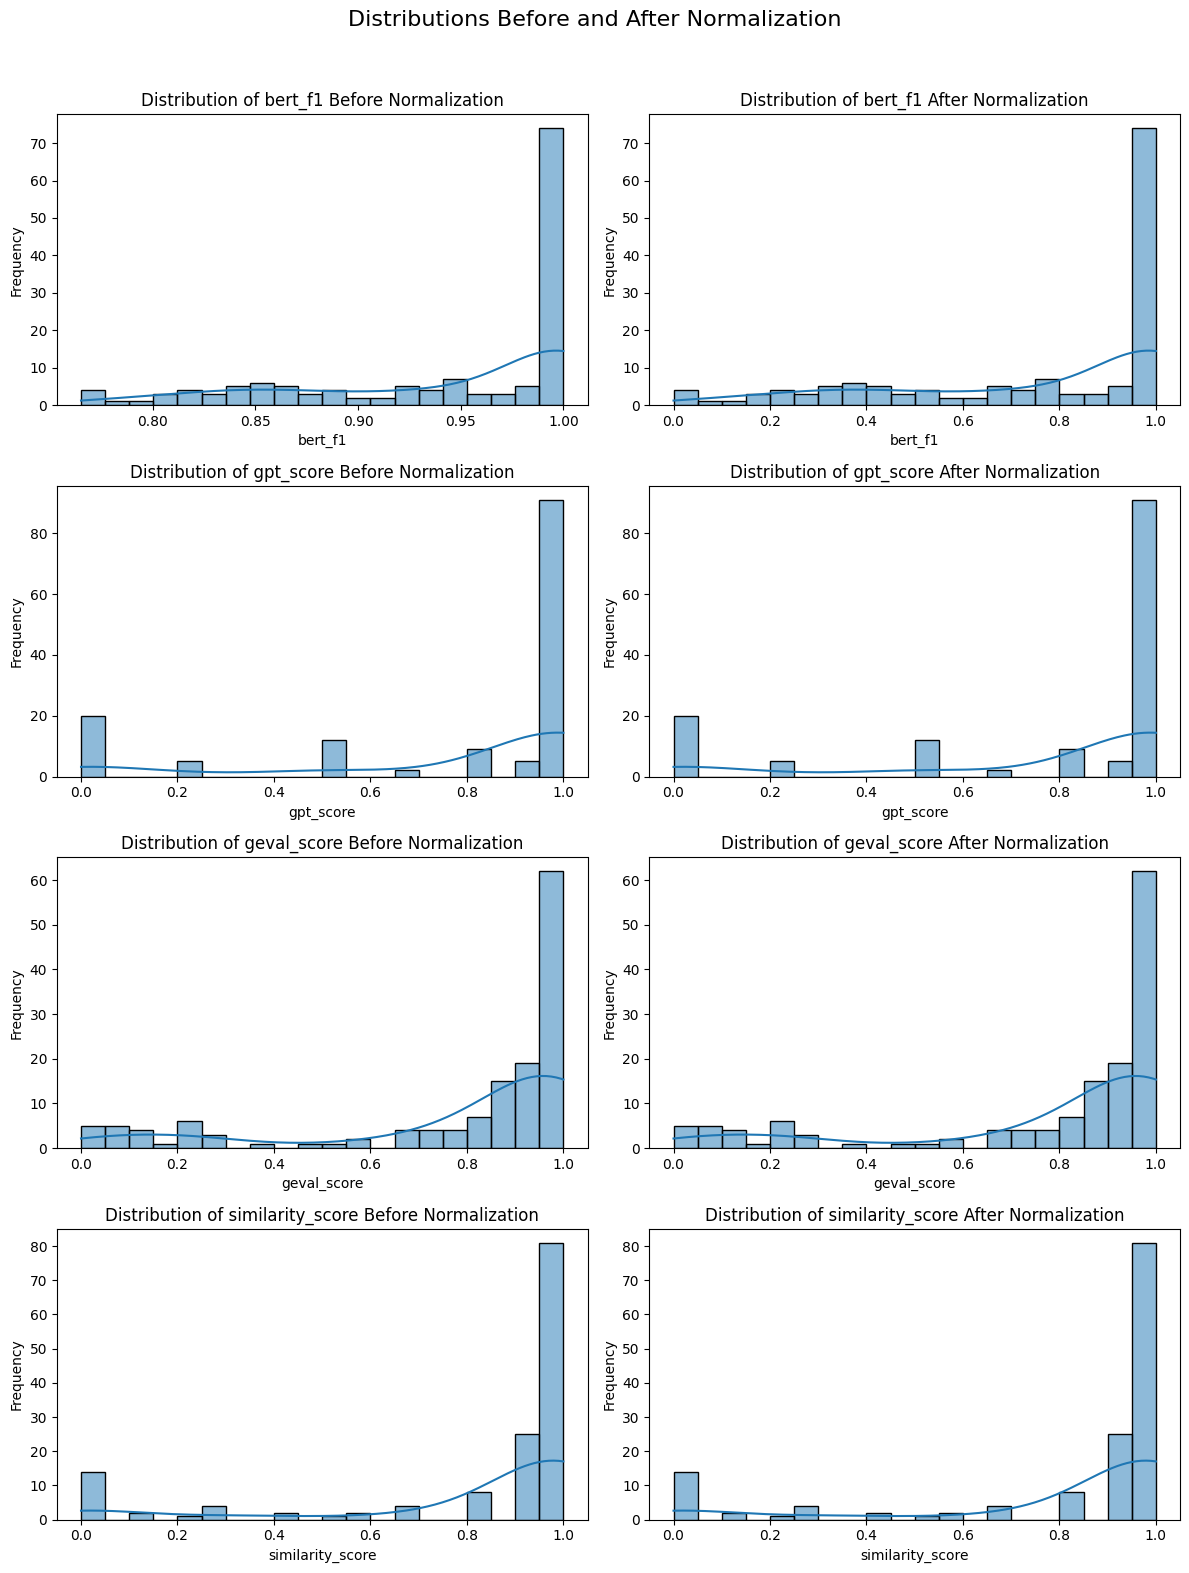

Correlation Results:
        Metric  Pearson Correlation  Pearson p-value  Spearman Correlation  \
0      bert_f1             0.777913     1.900734e-30              0.845181   
1    gpt_score             0.924048     3.601671e-61              0.935012   
2  geval_score             0.961752     9.660672e-82              0.910762   

   Spearman p-value  
0      1.832867e-40  
1      8.311356e-66  
2      2.088654e-56  

The metric with the highest Pearson correlation with the similarity_score is: geval_score
The metric with the highest Spearman correlation with the similarity_score is: gpt_score


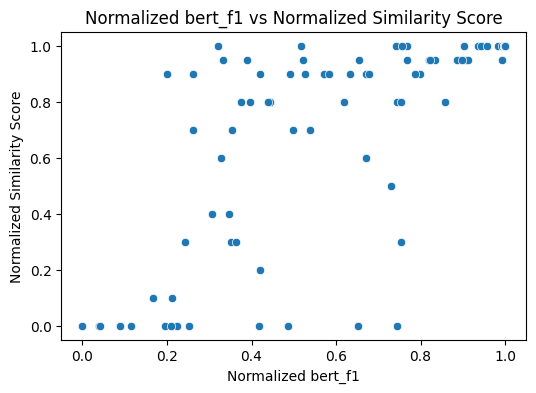

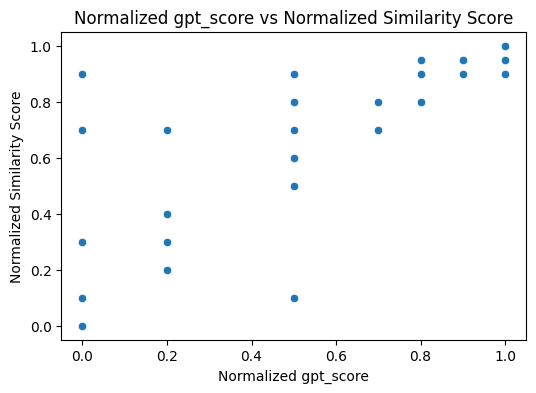

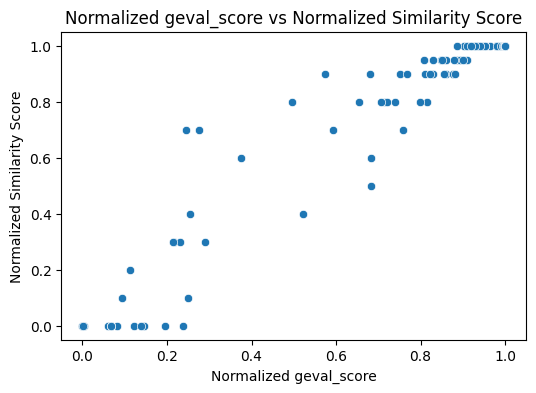

In [29]:
analyze_correlation('data/education/evaluation/education_i3p932d7_evaluated_llmeval_claude_similarity.csv')

### Evaluation metric correlation in healthcare

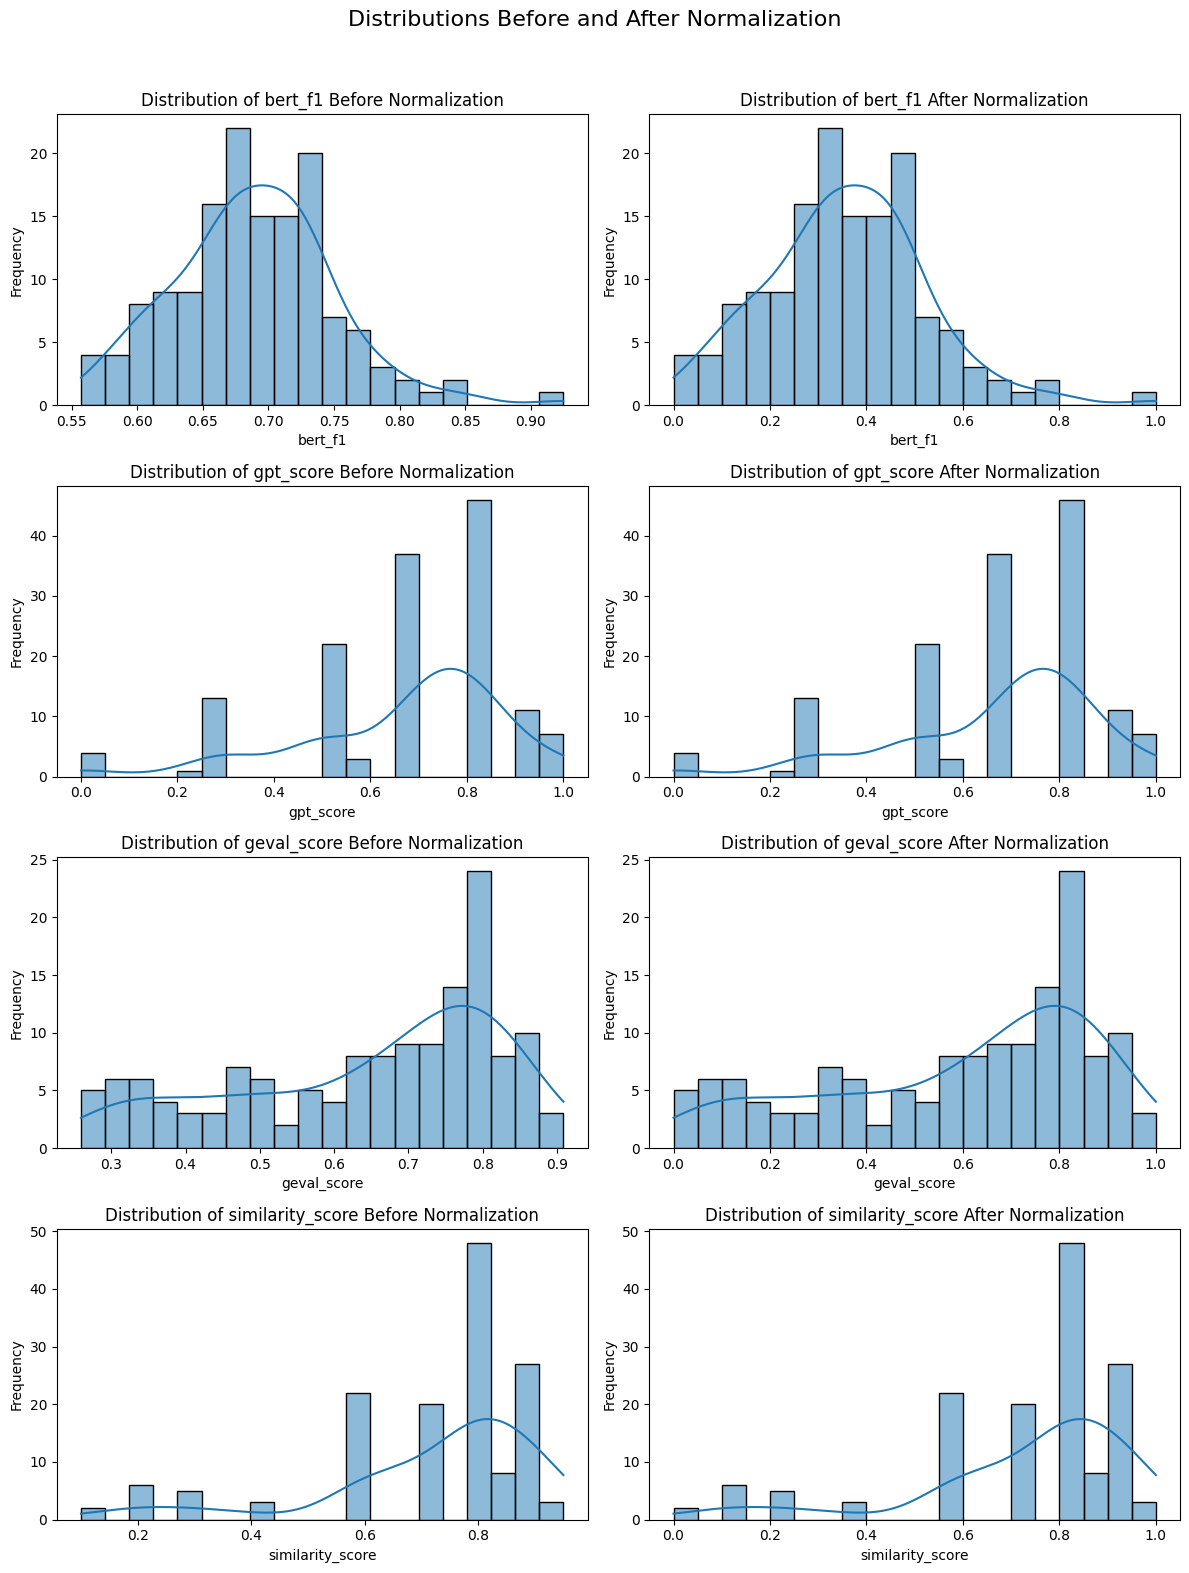

Correlation Results:
        Metric  Pearson Correlation  Pearson p-value  Spearman Correlation  \
0      bert_f1             0.451030     1.401831e-08              0.524747   
1    gpt_score             0.863246     5.356472e-44              0.812010   
2  geval_score             0.798116     4.737368e-33              0.828399   

   Spearman p-value  
0      1.466153e-11  
1      5.091236e-35  
2      1.456841e-37  

The metric with the highest Pearson correlation with the similarity_score is: gpt_score
The metric with the highest Spearman correlation with the similarity_score is: geval_score


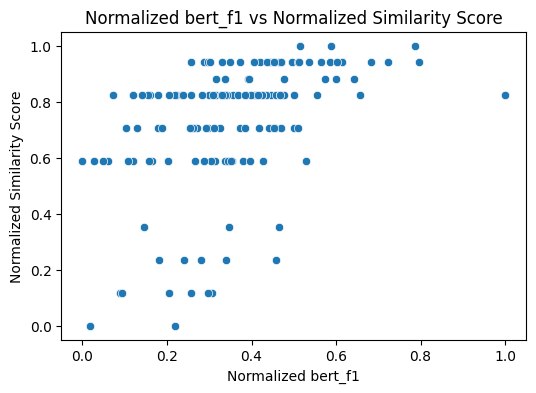

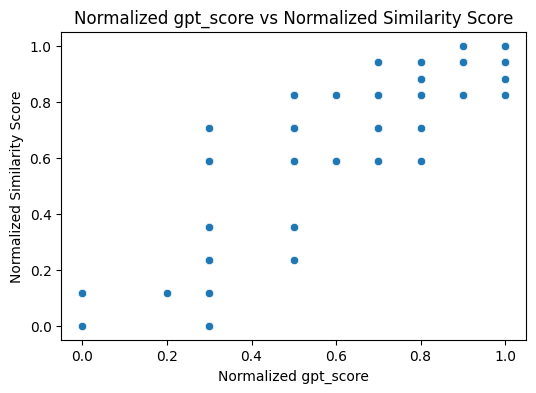

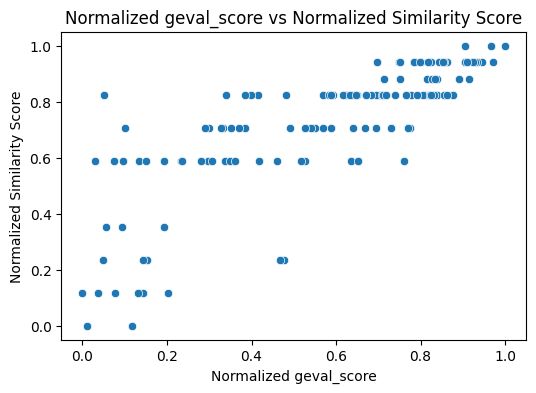

In [18]:
analyze_correlation('data/healthcare/evaluation/healthcare_mrwt3hwy_evaluated_llmeval_claude_similarity.csv')

### Retrieve hyperparameter combinations

In [36]:
# Function to evaluate gpt_score for a given answer pair
def evaluate_gpt_score(generated_answer, ground_truth, pre_prompt, model_name='gpt-4o'):
    prompt = f""" 
    {pre_prompt}.
    Provide a score between 0.0 and 1.0, where 1.0 indicates perfect alignment in terms of correctness, relevance, and completeness.
    
    Ground Truth:
    {ground_truth}
    
    Generated Answer:
    {generated_answer}
    
    Score (just the number):
    """
    
    try:
        client = openai.OpenAI()
        response = client.chat.completions.create(
            model=model_name,
            messages=[{"role": "user", "content": prompt}],
            max_tokens=10,
            temperature=0,
        )
        score_text = response.choices[0].message.content.strip()
        return float(score_text)
    except Exception as e:
        print(f"Error evaluating answer with OpenAI GPT: {e}")
        return None

# Function to retrieve combinations and calculate gpt_score
def retrieve_and_evaluate_combinations(pre_prompt, sweep_id, sector, project_name='rag-system-tuning', n_top=5, model='gpt-4o'):
    # Initialize the wandb API
    api = wandb.Api()

    # Set sector config
    sector_config = SECTORS[sector]

    # Retrieve the sweep
    sweep = api.sweep(f"{project_name}/{sweep_id}")
    runs = sweep.runs


    # Determine which metric is available in the runs
    score_metric = None
    for run in runs:
        if 'bert_f1' in run.summary:
            score_metric = 'bert_f1'
            break
        elif 'gemini_score_avg' in run.summary:
            score_metric = 'gemini_score_avg'
            break

    # Collect results
    results = []
    for run in runs:
        if score_metric in run.summary:
            results.append({
                'run_id': run.id,
                score_metric: run.summary[score_metric],
                'temperature': run.config['temperature'],
                'top_p': run.config['top_p'],
                'k': run.config['k']
            })

    results_df = pd.DataFrame(results).sort_values(by=score_metric, ascending=False).reset_index(drop=True)

    # Select top-performing and random combinations
    top_combinations = results_df.head(n_top)
    random_combinations = results_df.iloc[n_top:].sample(n=(10 - n_top), random_state=42)
    selected_combinations = pd.concat([top_combinations, random_combinations]).reset_index(drop=True)

    highest_avg_score = 0
    best_run = None

    for _, row in selected_combinations.iterrows():
        run_id = row['run_id']
        temperature = row['temperature']
        top_p = row['top_p']
        k = row['k']
        
        # Find the corresponding CSV file for the run
        file_pattern = f"tuning_logs/**/*{run_id}.csv"
        csv_files = glob.glob(file_pattern, recursive=True)

        if csv_files:
            csv_file = csv_files[0]
            print(f"Evaluating run {run_id} with parameters: temperature={temperature}, top_p={top_p}, k={k}")

            # Load the CSV file and evaluate it
            run_data = pd.read_csv(csv_file)
            gpt_scores = []
          
            for _, answer_row in run_data.iterrows():
                generated_answer = answer_row[sector_config['answer_column']]
                ground_truth = answer_row[sector_config['answer_truth']]

                gpt_score = evaluate_gpt_score(generated_answer, ground_truth, pre_prompt, model_name=model)
                if gpt_score is not None:
                    gpt_scores.append(gpt_score)

            # Calculate average gpt_score
            avg_gpt_score = sum(gpt_scores) / len(gpt_scores) if gpt_scores else 0

            print(f"Average GPT Score for run {run_id}: {avg_gpt_score}")

            # Track the run with the highest average GPT score
            if avg_gpt_score > highest_avg_score:
                highest_avg_score = avg_gpt_score
                best_run = {
                    'run_id': run_id,
                    'temperature': temperature,
                    'top_p': top_p,
                    'k': k,
                    'avg_gpt_score': avg_gpt_score
                }

    if best_run:
        print("\nBest performing run:")
        print(f"Run ID: {best_run['run_id']}")
        print(f"Parameters: temperature={best_run['temperature']}, top_p={best_run['top_p']}, k={best_run['k']}")
        print(f"Highest Average GPT Score: {best_run['avg_gpt_score']}")

In [9]:
# Define pre-prompts for different sectors and perform parameter evaluation
pre_prompt_education = "As an expert evaluator, compare the following generated answer with the ground truth"
retrieve_and_evaluate_combinations(pre_prompt_education, sweep_id='7gyw8rns', sector='education', n_top=5)

Evaluating run i3p932d7 with parameters: temperature=0.9755890902718948, top_p=0.882044010455027, k=7
Average GPT Score for run i3p932d7: 0.7715277777777777
Evaluating run 38noskn2 with parameters: temperature=0.9922578179417368, top_p=0.6639398434410994, k=7
Average GPT Score for run 38noskn2: 0.7770833333333333
Evaluating run ir11gg5u with parameters: temperature=0.9387307882682796, top_p=0.5759543464786252, k=7
Average GPT Score for run ir11gg5u: 0.7729166666666667
Evaluating run adnz89gp with parameters: temperature=0.8894789543465522, top_p=0.7599818020535836, k=7
Average GPT Score for run adnz89gp: 0.7673611111111112
Evaluating run f4wtqn15 with parameters: temperature=0.9609009023350698, top_p=0.8780895501668519, k=7
Average GPT Score for run f4wtqn15: 0.7708333333333334
Evaluating run larsd1g4 with parameters: temperature=0.9746344714578156, top_p=0.5714513638350773, k=7
Average GPT Score for run larsd1g4: 0.7708333333333334
Evaluating run s8mt5q06 with parameters: temperature=

#### Retuning for healthcare

For Healthcare, it was observed that the BERTScore, nor with the SCIBert model, would correlate well with the established ground truth of Claude's Sonnet score. Therefore, the alternative of Gemini 1.5 Flash was employed as a cost-effective alternative for healthcare to re-perform tuning and analysis.

In [9]:
def evaluate_answers_geminiflash(sector, pre_prompt, row, correctness_metric, model_choice='gemini-1.5-flash'):
    """
    Evaluates the generated answer against the ground truth using Gemini 1.5 Flash.
    Returns the score by Gemini.
    """
    sector_config = SECTORS[sector]
    generated_answer = row[sector_config['answer_column']]
    ground_truth = row[sector_config['answer_truth']]

    # Prompt for Gemini
    prompt = f"""
    {pre_prompt}.
    Provide a score between 0.0 and 1.0, where 1.0 indicates perfect alignment in terms of correctness, relevance, and completeness.
    
    Ground Truth:
    {ground_truth}
    
    Generated Answer:
    {generated_answer}
    
    Score (just the number):
    """

    try:
        # Load Gemini Model and score answer comparison
        model = genai.GenerativeModel(model_choice)
        message = model.generate_content(prompt)
        score_text = message.text.strip()
        gemini_score = float(score_text)
    except Exception as e:
        print(f"Error evaluating answer with Gemini 1.5 Flash: {e}")
        gemini_score = None

    return gemini_score

In [10]:
# Define sweep config
sweep_config = {
    'method': 'bayes',  # Bayesian optimization
    'metric': {
        'name': 'gemini_score_avg',
        'goal': 'maximize'
    },
    'parameters': {
        'temperature': {
            'distribution': 'uniform',  # Continuous distribution
            'min': 0.0,
            'max': 1.0
        },
        'top_p': {
            'distribution': 'uniform',  # Continuous distribution
            'min': 0.0,
            'max': 1.0
        },
        'k': {
            'values': [1, 2, 3, 5, 7]
        }
    }
}

# Initialize the sweep
sweep_id = wandb.sweep(sweep=sweep_config, project='rag-system-tuning')


def sweep_function(config=None):
    # Initialize a wandb run
    with wandb.init(config=config) as run:
        config = wandb.config
     
        # Select sector configuration
        sector_config = SECTORS['healthcare']
        
        # Extract hyperparameters from wandb config
        hyperparameters = {
            'top_p': config.top_p,
            'temperature':config.temperature,
            'k': config.k,
            'batch_size': sector_config['hyperparameters']['batch_size'],
            'max_retries': sector_config['hyperparameters']['max_retries'],
            'initial_delay': sector_config['hyperparameters']['initial_delay']
        }

        healthcare_valid_df[sector_config['answer_column']] = pd.NA
        
        # Initialize RAGSystem with current hyperparameters
        rag_system = RAGSystem(
            sector_config=sector_config,
            hyperparameters=hyperparameters,
            questions_df=healthcare_valid_df,
            faiss_index_path=None,
            model_name='gpt-4o-mini'
        )
        
        # Process questions and save to temp_output.csv
        rag_system.process_questions(start_index=0, output_path='temp_output.csv')

        # Load processed answers and compute GPT scores
        temp_output = pd.read_csv('temp_output.csv')

        # Define pre_prompt specific to healthcare
        pre_prompt_healthcare = "You are a healthcare expert evaluating AI-generated healthcare answers against ground truth."

        # Calculate Gemini scores for each row
        gemini_scores = temp_output.apply(
            lambda row: evaluate_answers_geminiflash('healthcare', pre_prompt_healthcare, row, 'correctness_metric'),
            axis=1
        )

        # Add Gemini scores to temp_output DataFrame
        temp_output['gemini_score'] = gemini_scores

        # Calculate average Gemini score for logging
        gemini_score_avg = gemini_scores.mean()
        
        # Log the score to wandb
        wandb.log({
            'gemini_score_avg': gemini_score_avg
        })
        
        run_id = run.id

        # Get current date and time
        now = datetime.now()
        current_date = now.strftime('%Y-%m-%d')
        current_time = now.strftime('%H%M%S')
        
        # Define the directory path: tuning_logs/YYYY-MM-DD/
        output_dir = os.path.join('tuning_logs', current_date, sweep_id)
        
        # Create the directory if it doesn't exist
        os.makedirs(output_dir, exist_ok=True)
        
        # Define the filename with timestamp and run ID
        output_filename = f'{current_time}_output_{run_id}.csv'
        
        # Full path to save the CSV
        output_path = os.path.join(output_dir, output_filename)
        
        # Save the DataFrame to the specified path
        temp_output.to_csv(output_path, index=False)
        
        # Clean up
        os.remove('temp_output.csv')

wandb: Using wandb-core as the SDK backend. Please refer to https://wandb.me/wandb-core for more information.


Create sweep with ID: slm1j48o
Sweep URL: https://wandb.ai/genai-proj/rag-system-tuning/sweeps/slm1j48o


In [11]:
wandb.agent(sweep_id, function=sweep_function, count=30) 

wandb: Agent Starting Run: oc0jfj7h with config:
wandb: 	k: 2
wandb: 	temperature: 0.33342372815281784
wandb: 	top_p: 0.9016956897478212
wandb: Currently logged in as: eodic (genai-proj). Use `wandb login --relogin` to force relogin


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.54097


wandb: Agent Starting Run: 4nu99m9r with config:
wandb: 	k: 7
wandb: 	temperature: 0.24393110804567453
wandb: 	top_p: 0.0009511460778550695


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60069


wandb: Agent Starting Run: ek9bd1tt with config:
wandb: 	k: 7
wandb: 	temperature: 0.9370627399428416
wandb: 	top_p: 0.3794889604718531


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.59931


wandb: Agent Starting Run: evj1tlqy with config:
wandb: 	k: 7
wandb: 	temperature: 0.4397764026660975
wandb: 	top_p: 0.13640642274323644


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.59896


wandb: Agent Starting Run: 88k5vlnk with config:
wandb: 	k: 7
wandb: 	temperature: 0.9670338291333526
wandb: 	top_p: 0.03408412675354178


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.59583


wandb: Agent Starting Run: uyqjtrf4 with config:
wandb: 	k: 3
wandb: 	temperature: 0.8787317733767939
wandb: 	top_p: 0.0023472862150082374


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.54167


wandb: Agent Starting Run: 770ymhwh with config:
wandb: 	k: 7
wandb: 	temperature: 0.1440695942195962
wandb: 	top_p: 0.2322512726691549


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.59861


wandb: Agent Starting Run: 0hp4bygr with config:
wandb: 	k: 7
wandb: 	temperature: 0.965680092008415
wandb: 	top_p: 0.776678647459978


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60347


wandb: Agent Starting Run: je7yy163 with config:
wandb: 	k: 7
wandb: 	temperature: 0.9532856605183804
wandb: 	top_p: 0.985953617708552


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60208


wandb: Agent Starting Run: 0v1ggsp8 with config:
wandb: 	k: 7
wandb: 	temperature: 0.593387217770526
wandb: 	top_p: 0.5712134810652868


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60556


wandb: Agent Starting Run: 2g27ln9n with config:
wandb: 	k: 7
wandb: 	temperature: 0.712950931446654
wandb: 	top_p: 0.7093959249668175


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60347


wandb: Agent Starting Run: b5e3rspp with config:
wandb: 	k: 7
wandb: 	temperature: 0.3289329043038022
wandb: 	top_p: 0.5674117115379638


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60139


wandb: Agent Starting Run: fbvpq5ri with config:
wandb: 	k: 7
wandb: 	temperature: 0.2617593779728026
wandb: 	top_p: 0.9995597655932696


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60208


wandb: Agent Starting Run: qgwui6g1 with config:
wandb: 	k: 7
wandb: 	temperature: 0.6303818820787945
wandb: 	top_p: 0.9717240920573076


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.61458


wandb: Agent Starting Run: aylcc37g with config:
wandb: 	k: 7
wandb: 	temperature: 0.4672955956655155
wandb: 	top_p: 0.8906783217180521


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60833


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: xzyytd6a with config:
wandb: 	k: 7
wandb: 	temperature: 0.7026501440643217
wandb: 	top_p: 0.9018307564661164


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60347


wandb: Agent Starting Run: 3kjvunee with config:
wandb: 	k: 7
wandb: 	temperature: 0.4784890125028513
wandb: 	top_p: 0.980777161524974


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.6125


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: l6qxbhp6 with config:
wandb: 	k: 1
wandb: 	temperature: 0.0043725340148024205
wandb: 	top_p: 0.0076423901046661635


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.47569


wandb: Agent Starting Run: 596o9hna with config:
wandb: 	k: 7
wandb: 	temperature: 0.6040916872640072
wandb: 	top_p: 0.9851214703525428


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60694


wandb: Agent Starting Run: ymv0deur with config:
wandb: 	k: 5
wandb: 	temperature: 0.9613019607373552
wandb: 	top_p: 0.9961260823192


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.59167


wandb: Agent Starting Run: htn7f0vo with config:
wandb: 	k: 1
wandb: 	temperature: 0.9870610925897756
wandb: 	top_p: 0.8967223336387181


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.48333


wandb: Agent Starting Run: h9wv318z with config:
wandb: 	k: 7
wandb: 	temperature: 0.048819540689170715
wandb: 	top_p: 0.7574113164534128


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60208


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: kqcxorbg with config:
wandb: 	k: 7
wandb: 	temperature: 0.6519817313159395
wandb: 	top_p: 0.3705907771397783


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60069


wandb: Sweep Agent: Waiting for job.
wandb: Job received.
wandb: Agent Starting Run: cokwqmg5 with config:
wandb: 	k: 7
wandb: 	temperature: 0.034922695921503766
wandb: 	top_p: 0.45531155189387584


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60174


wandb: Agent Starting Run: jdn8fl2l with config:
wandb: 	k: 7
wandb: 	temperature: 0.027661928627658705
wandb: 	top_p: 0.9839746912205188


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.59757


wandb: Agent Starting Run: cky21777 with config:
wandb: 	k: 7
wandb: 	temperature: 0.7302040433887156
wandb: 	top_p: 0.9822050796271712


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.58889


wandb: Agent Starting Run: xuytcwop with config:
wandb: 	k: 7
wandb: 	temperature: 0.6319928205618941
wandb: 	top_p: 0.9426725308785427


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60417


wandb: Agent Starting Run: kiumpwsz with config:
wandb: 	k: 7
wandb: 	temperature: 0.2833656590413671
wandb: 	top_p: 0.7833139646309747


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60417


wandb: Agent Starting Run: rqci8r7h with config:
wandb: 	k: 7
wandb: 	temperature: 0.4012460963322597
wandb: 	top_p: 0.9449139318210974


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60486


wandb: Agent Starting Run: 5l2efa9n with config:
wandb: 	k: 7
wandb: 	temperature: 0.8426327191989371
wandb: 	top_p: 0.6237711044385338


Loading FAISS index from ..\models\embeddings\pubmedqa_faiss_index_subset.idx...
Progress saved at question 5/144.
Progress saved at question 10/144.
Progress saved at question 15/144.
Progress saved at question 20/144.
Progress saved at question 25/144.
Progress saved at question 30/144.
Progress saved at question 35/144.
Progress saved at question 40/144.
Progress saved at question 45/144.
Progress saved at question 50/144.
Progress saved at question 55/144.
Progress saved at question 60/144.
Progress saved at question 65/144.
Progress saved at question 70/144.
Progress saved at question 75/144.
Progress saved at question 80/144.
Progress saved at question 85/144.
Progress saved at question 90/144.
Progress saved at question 95/144.
Progress saved at question 100/144.
Progress saved at question 105/144.
Progress saved at question 110/144.
Progress saved at question 115/144.
Progress saved at question 120/144.
Progress saved at question 125/144.
Progress saved at question 130/144.
Pro

gemini_score_avg,▁
gemini_score_avg,0.60694


#### Re-running analysis

In [14]:
# Define the ID for healthcare's best run and retrieve logs
hc_sweep_id = "qgwui6g1"
file_pattern = f"tuning_logs/**/*{hc_sweep_id}.csv"
csv_file_hc = glob.glob(file_pattern, recursive=True)
print(csv_file_hc[0])

tuning_logs\2024-11-12\slm1j48o\135242_output_qgwui6g1.csv


In [15]:
pre_prompt_healthcare = "You are a healthcare expert in evaluating AI-generated healthcare answers compared with their ground truth"

In [18]:
print("\n=== Healthcare Sector ===")
# Read corresponding file
df_healthcare = pd.read_csv(csv_file_hc[0])

df_healthcare['geval_score'] = df_healthcare.apply(
    lambda row: evaluate_answers_geval('healthcare', row, correctness_metric), axis=1
)



=== Healthcare Sector ===


C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Event loop is already running. Applying nest_asyncio patch to allow async execution...

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

C:\Users\Emir\Documents\Training\VS Code\Master-Arbeit\master-thesis\venv\Lib\site-packages\rich\live.py:231: 
UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

In [19]:
df_healthcare['gpt_score'] = df_healthcare.apply(
    lambda row: evaluate_answers_gpt('healthcare', pre_prompt_healthcare, row, correctness_metric), axis=1
)

hc_name = f"data/healthcare/evaluation/healthcare_{hc_sweep_id}_evaluated"
df_healthcare.to_csv(f"{hc_name}.csv")

In [20]:
# Define the ID for healthcare's best run and retrieve logs
hc_sweep_id = "qgwui6g1"
file_pattern = f"data/healthcare/evaluation/*{hc_sweep_id}*.csv"
csv_file_hc = glob.glob(file_pattern, recursive=True)
print(csv_file_hc[0])

data/healthcare/evaluation\healthcare_qgwui6g1_evaluated.csv


In [24]:
df_healthcare = pd.read_csv(csv_file_hc[0])
hc_name = f"healthcare_{hc_sweep_id}_evaluated"

evaluate_dataset_claude(df_healthcare, 'healthcare', hc_name, pre_prompt_healthcare)

Evaluating Similarity Scores: 100%|██████████████████████████████████████████████████| 144/144 [03:09<00:00,  1.32s/it]



Evaluation complete. Output saved to 'healthcare_qgwui6g1_evaluated_llmeval_claude_similarity.csv'.


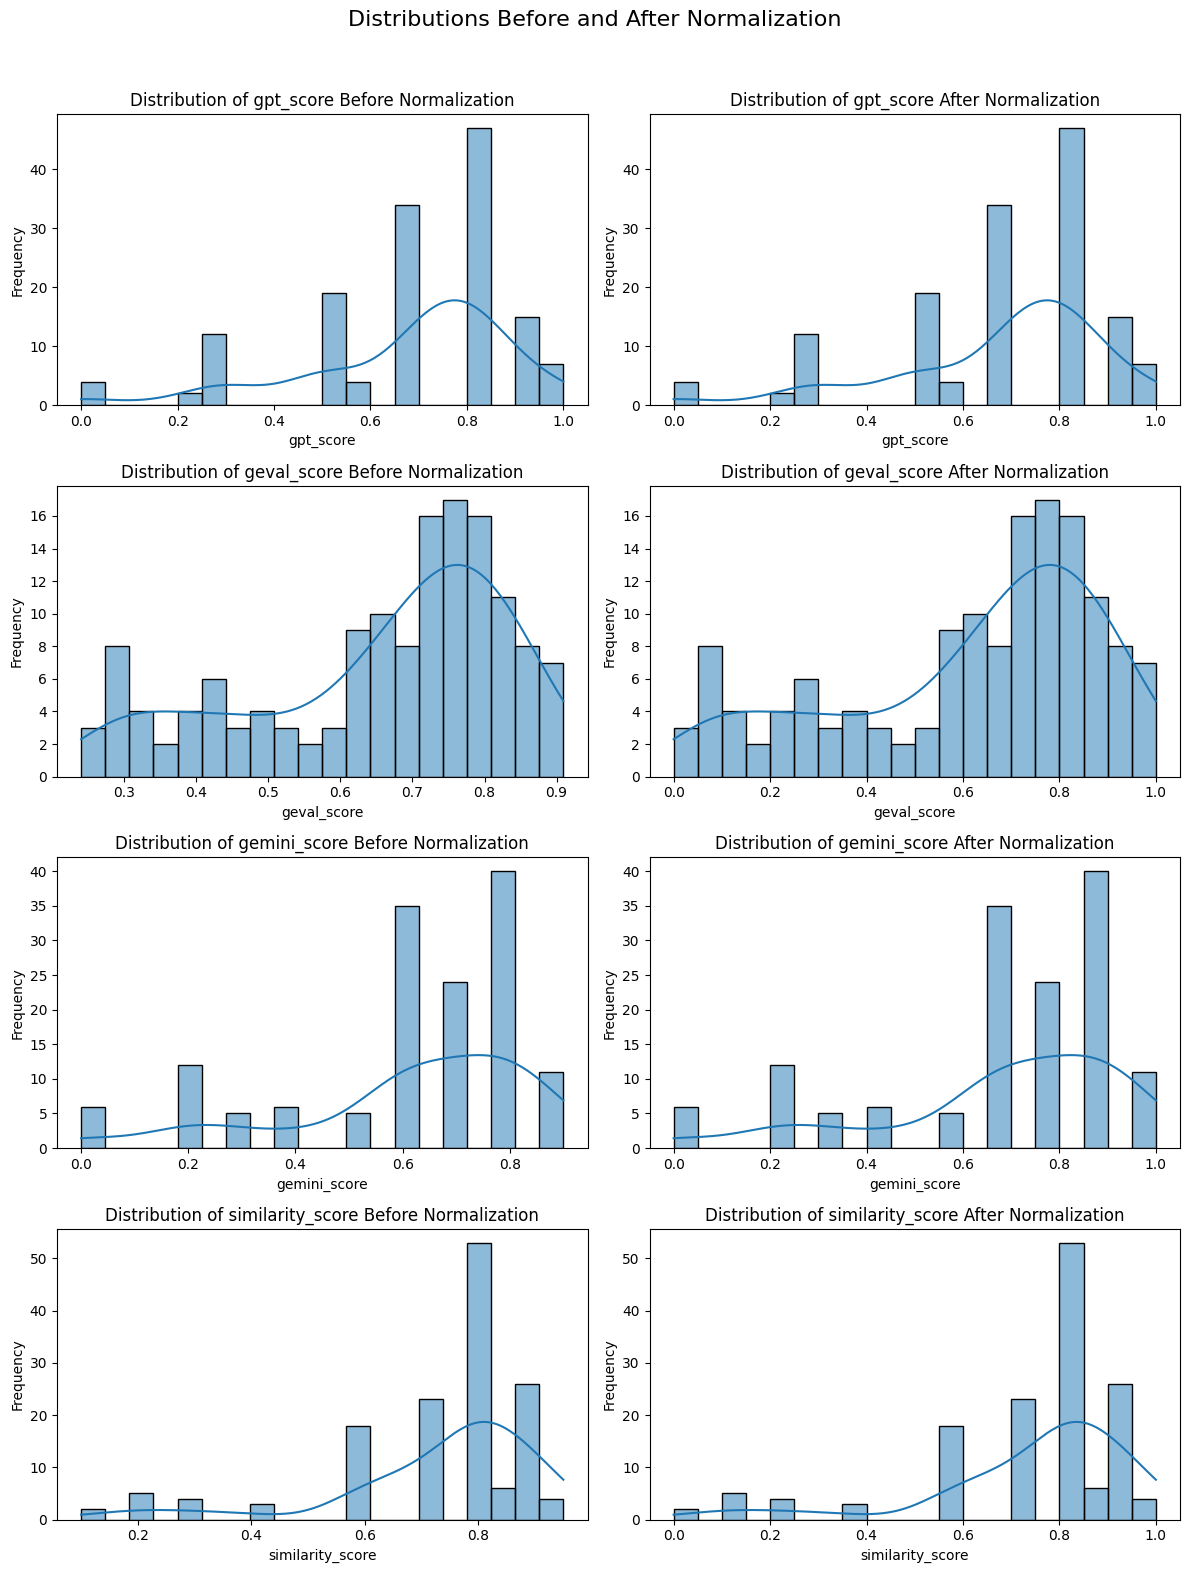

Correlation Results:
         Metric  Pearson Correlation  Pearson p-value  Spearman Correlation  \
0     gpt_score             0.872298     5.783385e-46              0.823458   
1   geval_score             0.808223     1.816947e-34              0.856485   
2  gemini_score             0.856961     1.030801e-42              0.785138   

   Spearman p-value  
0      9.072704e-37  
1      1.282448e-42  
2      2.400329e-31  

The metric with the highest Pearson correlation with the similarity_score is: gpt_score
The metric with the highest Spearman correlation with the similarity_score is: geval_score


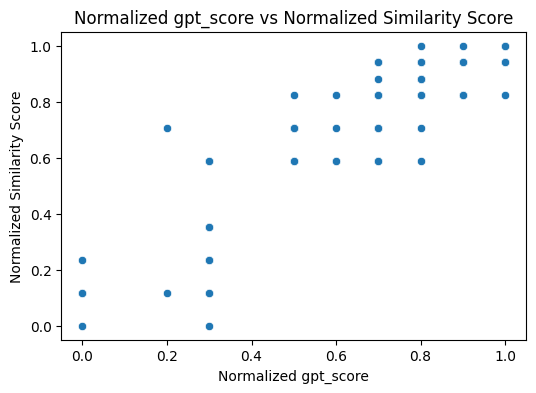

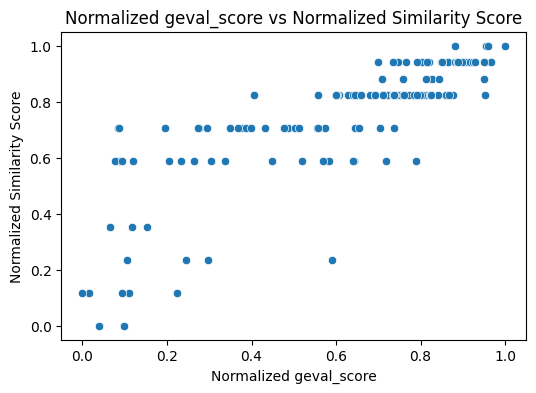

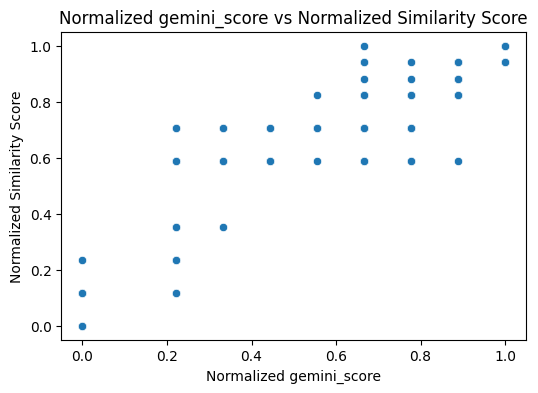

In [25]:
analyze_correlation('data/healthcare/evaluation/healthcare_qgwui6g1_evaluated_llmeval_claude_similarity.csv')

In [37]:
# Define pre-prompts for different sectors
pre_prompt_healthcare = "You are a healthcare expert in evaluating AI-generated healthcare answers compared with their ground truth"
retrieve_and_evaluate_combinations(pre_prompt_healthcare, sweep_id='slm1j48o', sector='healthcare', n_top=5)

Evaluating run qgwui6g1 with parameters: temperature=0.6303818820787945, top_p=0.9717240920573076, k=7
Average GPT Score for run qgwui6g1: 0.6798611111111111
Evaluating run 3kjvunee with parameters: temperature=0.4784890125028513, top_p=0.980777161524974, k=7
Average GPT Score for run 3kjvunee: 0.6715277777777778
Evaluating run aylcc37g with parameters: temperature=0.4672955956655155, top_p=0.8906783217180521, k=7
Average GPT Score for run aylcc37g: 0.6652777777777777
Evaluating run 5l2efa9n with parameters: temperature=0.8426327191989371, top_p=0.6237711044385338, k=7
Average GPT Score for run 5l2efa9n: 0.6784722222222223
Evaluating run 596o9hna with parameters: temperature=0.6040916872640072, top_p=0.9851214703525428, k=7
Average GPT Score for run 596o9hna: 0.675
Evaluating run fbvpq5ri with parameters: temperature=0.2617593779728026, top_p=0.9995597655932696, k=7
Average GPT Score for run fbvpq5ri: 0.6652777777777777
Evaluating run 770ymhwh with parameters: temperature=0.14406959421